# ImagoAI Task

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

def clean_column_names(df):
    """
    Clean column names by removing special characters and converting to lowercase.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Dataset with cleaned column names
    """
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    return df

In [2]:
def remove_duplicates(df):
    """
    Remove duplicate rows from the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Dataset without duplicates
    """
    initial_rows = len(df)
    df = df.drop_duplicates()
    removed_rows = initial_rows - len(df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} duplicate rows")
    return df

In [3]:
def handle_missing_values(df, method='mean', strategy='global'):
    """
    Handle missing values in the dataset using specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        method (str): Method to use ('mean', 'median', 'mode', or 'drop')
        strategy (str): Imputation strategy ('global' or 'column_wise')
        
    Returns:
        pd.DataFrame: Dataset with handled missing values
    """
    missing_counts = df.isnull().sum()
    if missing_counts.any():
        print("\nMissing values before handling:")
        print(missing_counts[missing_counts > 0])
        
        if method == 'drop':
            initial_rows = len(df)
            df = df.dropna()
            removed_rows = initial_rows - len(df)
            print(f"\nDropped {removed_rows} rows with missing values")
        else:
            print(f"\nPerforming {method} imputation with {strategy} strategy...")
            
            if strategy == 'global':
                # Calculate global statistics
                if method == 'mean':
                    fill_value = df.mean().mean()
                elif method == 'median':
                    fill_value = df.median().median()
                elif method == 'mode':
                    fill_value = df.mode().mode().iloc[0]
                
                # Fill all missing values with the global statistic
                df = df.fillna(fill_value)
                print(f"Global {method} value used: {fill_value:.4f}")
            
            else:  # column_wise strategy
                for column in df.columns:
                    if df[column].isnull().any():
                        if method == 'mean':
                            fill_value = df[column].mean()
                        elif method == 'median':
                            fill_value = df[column].median()
                        elif method == 'mode':
                            fill_value = df[column].mode()[0]
                        
                        missing_count = df[column].isnull().sum()
                        df[column] = df[column].fillna(fill_value)
                        print(f"Column '{column}': {missing_count} missing values filled with {method} value: {fill_value:.4f}")
        
        print("\nMissing values after handling:")
        remaining_missing = df.isnull().sum()
        if remaining_missing.any():
            print(remaining_missing[remaining_missing > 0])
        else:
            print("No missing values remaining")
    
    return df

In [4]:
def transform_target_variable(y, method='log'):
    """
    Transform the target variable to handle extreme values.
    
    Args:
        y (pd.Series): Target variable
        method (str): Transformation method ('log', 'sqrt', or 'box_cox')
        
    Returns:
        pd.Series: Transformed target variable
    """
    if method == 'log':
        # Add small constant to handle zero values
        return np.log1p(y)
    elif method == 'sqrt':
        return np.sqrt(y)
    elif method == 'box_cox':
        from scipy import stats
        # Find optimal lambda for Box-Cox transformation
        y_transformed, lambda_param = stats.boxcox(y + 1)
        print(f"Box-Cox transformation lambda: {lambda_param:.4f}")
        return y_transformed
    return y

In [5]:
def handle_outliers(df, columns, method='iqr', threshold=3):
    """
    Handle outliers in the dataset using specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        columns (list): List of columns to check for outliers
        method (str): Method to use ('zscore', 'iqr', or 'isolation_forest')
        threshold (float): Threshold for outlier detection
        
    Returns:
        pd.DataFrame: Dataset with handled outliers
    """
    """Handle outliers in the dataset using specified method."""
    df_cleaned = df.copy()
    
    # Filter to include only numeric columns
    numeric_columns = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]
    print(f"Processing {len(numeric_columns)} numeric columns for outlier detection")
    
    for column in numeric_columns:
        if method == 'zscore':
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            # Instead of masking, use clipping for better handling
            df_cleaned[column] = df[column].clip(
                lower=df[column].mean() - threshold * df[column].std(),
                upper=df[column].mean() + threshold * df[column].std()
            )
        elif method == 'iqr':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            df_cleaned[column] = df[column].clip(lower_bound, upper_bound)
        elif method == 'isolation_forest':
            from sklearn.ensemble import IsolationForest
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            outliers = iso_forest.fit_predict(df[[column]])
            # Replace outliers with median
            df_cleaned.loc[outliers == -1, column] = df[column].median()
    
    return df_cleaned


In [6]:
def create_spectral_indices(df):
    """
    Create spectral indices from the hyperspectral data.
    
    Args:
        df (pd.DataFrame): Input dataset with spectral bands
        
    Returns:
        pd.DataFrame: Dataset with additional spectral indices
    """
    df_with_indices = df.copy()
    
    # Get spectral columns (only include numeric columns and exclude target)
    spectral_cols = [col for col in df.columns if col != 'vomitoxin_ppb' and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Identified {len(spectral_cols)} spectral bands for processing")
    
    # Calculate derivative spectra
    for i in range(1, len(spectral_cols)):
        df_with_indices[f'derivative_{i}'] = df[spectral_cols[i]] - df[spectral_cols[i-1]]
    
    # Calculate band ratios (limiting to avoid too many features)
    step = max(1, len(spectral_cols) // 20)  # Create ratios for about 5% of bands
    for i in range(0, len(spectral_cols)-1, step):
        for j in range(i+step, len(spectral_cols), step*2):
            if j < len(spectral_cols):  # Ensure j is within bounds
                ratio_name = f'ratio_{i}_{j}'
                df_with_indices[ratio_name] = df[spectral_cols[i]] / (df[spectral_cols[j]] + 1e-6)
    
    # Calculate normalized difference indices (limiting to avoid too many features)
    for i in range(0, len(spectral_cols)-1, step):
        for j in range(i+step, len(spectral_cols), step*2):
            if j < len(spectral_cols):  # Ensure j is within bounds
                ndi_name = f'ndi_{i}_{j}'
                df_with_indices[ndi_name] = (df[spectral_cols[i]] - df[spectral_cols[j]]) / (df[spectral_cols[i]] + df[spectral_cols[j]] + 1e-6)
    
    return df_with_indices

In [7]:
def normalize_data(df, target_column, method='robust'):
    """
    Normalize the features using specified method.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        method (str): Normalization method ('standard', 'minmax', or 'robust')
        
    Returns:
        tuple: (X_normalized, y, scaler)
    """
    # Select only numeric columns for X (excluding the target column)
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols if col != target_column]
    X = df[feature_cols]
    y = df[target_column]
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:  # robust
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
    
    X_normalized = scaler.fit_transform(X)
    return X_normalized, y, scaler

In [8]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Split the data into training and testing sets.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Target values
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [9]:
def plot_spectral_reflectance(df, target_column):
    """
    Plot average spectral reflectance across wavelengths.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
    """
    try:
        # Only select numeric columns and exclude target column
        numeric_cols = df.select_dtypes(include=['number']).columns
        spectral_cols = [col for col in numeric_cols if col != target_column]
        
        plt.figure(figsize=(12, 6))
        
        # Plot using numeric indices instead of actual column names
        wavelength_indices = range(len(spectral_cols))
        reflectance_values = df[spectral_cols].mean().values
        
        plt.plot(wavelength_indices, reflectance_values)
        
        # Add minimal x-ticks to avoid overcrowding
        tick_interval = max(1, len(spectral_cols) // 10)
        plt.xticks(wavelength_indices[::tick_interval])
        
        plt.xlabel('Spectral Band Index')
        plt.ylabel('Average Reflectance')
        plt.title('Average Spectral Reflectance Across Bands')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in spectral reflectance plot: {e}")


In [10]:
def create_heatmap(df, target_column, n_bands=20):
    """
    Create a correlation heatmap between the target and spectral bands.
    
    Args:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        n_bands (int): Number of bands to include in heatmap (to avoid overcrowding)
    """
    try:
        # Select only numeric columns
        numeric_cols = df.select_dtypes(include=['number']).columns
        
        # Create a new dataframe with only numeric columns
        numeric_df = df[numeric_cols].copy()
        
        # If there are too many columns, select a subset for the heatmap
        if len(numeric_cols) > n_bands + 1:  # +1 for target column
            # Always include target column
            cols_to_keep = [target_column]
            
            # Get spectral columns (excluding target)
            spectral_cols = [col for col in numeric_cols if col != target_column]
            
            # Sample evenly across the spectrum
            step = len(spectral_cols) // n_bands
            selected_cols = spectral_cols[::step][:n_bands]  # Limit to n_bands
            
            # Combine target with selected spectral bands
            cols_to_keep.extend(selected_cols)
            
            # Create subset dataframe
            heatmap_df = numeric_df[cols_to_keep]
        else:
            heatmap_df = numeric_df
            
        # Calculate correlation matrix
        corr_matrix = heatmap_df.corr()
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
        plt.title(f'Correlation Heatmap with {target_column}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in heatmap creation: {e}")


In [11]:
def clean_data(df):
    """
    Perform comprehensive data cleaning.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Cleaned dataset
    """
    print("\nInitial data shape:", df.shape)
    
    # Clean column names
    df = clean_column_names(df)
    
    # Remove duplicates
    df = remove_duplicates(df)
    
    # Handle missing values with detailed reporting
    print("\nHandling missing values...")
    df = handle_missing_values(df, method='mean', strategy='column_wise')
    
    # Create spectral indices
    print("\nCreating spectral indices...")
    df = create_spectral_indices(df)
    
    # Handle outliers
    print("\nHandling outliers...")
    spectral_cols = [col for col in df.columns if col != 'vomitoxin_ppb']
    df = handle_outliers(df, spectral_cols, method='iqr', threshold=3)
    
    # Transform target variable
    print("\nTransforming target variable...")
    df['vomitoxin_ppb'] = transform_target_variable(df['vomitoxin_ppb'], method='log')
    
    print("Final data shape:", df.shape)
    return df

In [12]:
def load_data(file_path):
    """Load and clean the hyperspectral data from CSV file."""
    try:
        # Load data
        df = pd.read_csv(file_path)
        print("\nData loaded successfully")
        
        # Clean data
        try:
            df = clean_data(df)
            return df
        except Exception as e:
            print(f"Error during data cleaning: {e}")
            import traceback
            traceback.print_exc()
            return None
            
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [13]:
def check_missing_values(df):
    """
    Check for missing values in the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        dict: Dictionary containing missing value information
    """
    missing_info = {
        'missing_counts': df.isnull().sum(),
        'missing_percentages': (df.isnull().sum() / len(df)) * 100
    }
    return missing_info 

In [14]:
def print_data_info(df):
    """
    Print detailed information about the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
    """
    print("\nDataset Information:")
    print("-" * 50)
    print(f"Total samples: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print("\nFeature names:")
    for col in df.columns:
        print(f"- {col}")
    print("\nData types:")
    print(df.dtypes)
    print("\nBasic statistics:")
    print(df.describe())

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and clean data
data_path = os.path.join('data', 'TASK-ML-INTERN.csv')
df = load_data(data_path)

# Print detailed data information
if df is not None:
    print_data_info(df)
else:
    print("Data loading failed. Cannot print information.")


Using device: cuda:0

Data loaded successfully

Initial data shape: (500, 450)

Handling missing values...

Creating spectral indices...
Identified 448 spectral bands for processing


C:\Users\priti\AppData\Local\Temp\ipykernel_10604\1277648827.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_indices[f'derivative_{i}'] = df[spectral_cols[i]] - df[spectral_cols[i-1]]
C:\Users\priti\AppData\Local\Temp\ipykernel_10604\1277648827.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_indices[f'derivative_{i}'] = df[spectral_cols[i]] - df[spectral_cols[i-1]]
C:\Users\priti\AppData\Local\Temp\ipykernel_10604\1277648827.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the


Handling outliers...
Processing 1115 numeric columns for outlier detection

Transforming target variable...
Final data shape: (500, 1117)

Dataset Information:
--------------------------------------------------
Total samples: 500
Number of features: 1117

Feature names:
- hsi_id
- 0
- 1
- 2
- 3
- 4
- 5
- 6
- 7
- 8
- 9
- 10
- 11
- 12
- 13
- 14
- 15
- 16
- 17
- 18
- 19
- 20
- 21
- 22
- 23
- 24
- 25
- 26
- 27
- 28
- 29
- 30
- 31
- 32
- 33
- 34
- 35
- 36
- 37
- 38
- 39
- 40
- 41
- 42
- 43
- 44
- 45
- 46
- 47
- 48
- 49
- 50
- 51
- 52
- 53
- 54
- 55
- 56
- 57
- 58
- 59
- 60
- 61
- 62
- 63
- 64
- 65
- 66
- 67
- 68
- 69
- 70
- 71
- 72
- 73
- 74
- 75
- 76
- 77
- 78
- 79
- 80
- 81
- 82
- 83
- 84
- 85
- 86
- 87
- 88
- 89
- 90
- 91
- 92
- 93
- 94
- 95
- 96
- 97
- 98
- 99
- 100
- 101
- 102
- 103
- 104
- 105
- 106
- 107
- 108
- 109
- 110
- 111
- 112
- 113
- 114
- 115
- 116
- 117
- 118
- 119
- 120
- 121
- 122
- 123
- 124
- 125
- 126
- 127
- 128
- 129
- 130
- 131
- 132
- 133
- 134
- 135
- 136
- 137
-

In [16]:
# Check for missing values
print("\nChecking for missing values...")
missing_info = check_missing_values(df)
print("\nMissing value counts:")
print(missing_info['missing_counts'][missing_info['missing_counts'] > 0])
print("\nMissing value percentages:")
print(missing_info['missing_percentages'][missing_info['missing_percentages'] > 0])


Checking for missing values...

Missing value counts:
Series([], dtype: int64)

Missing value percentages:
Series([], dtype: float64)



Generating initial visualizations...


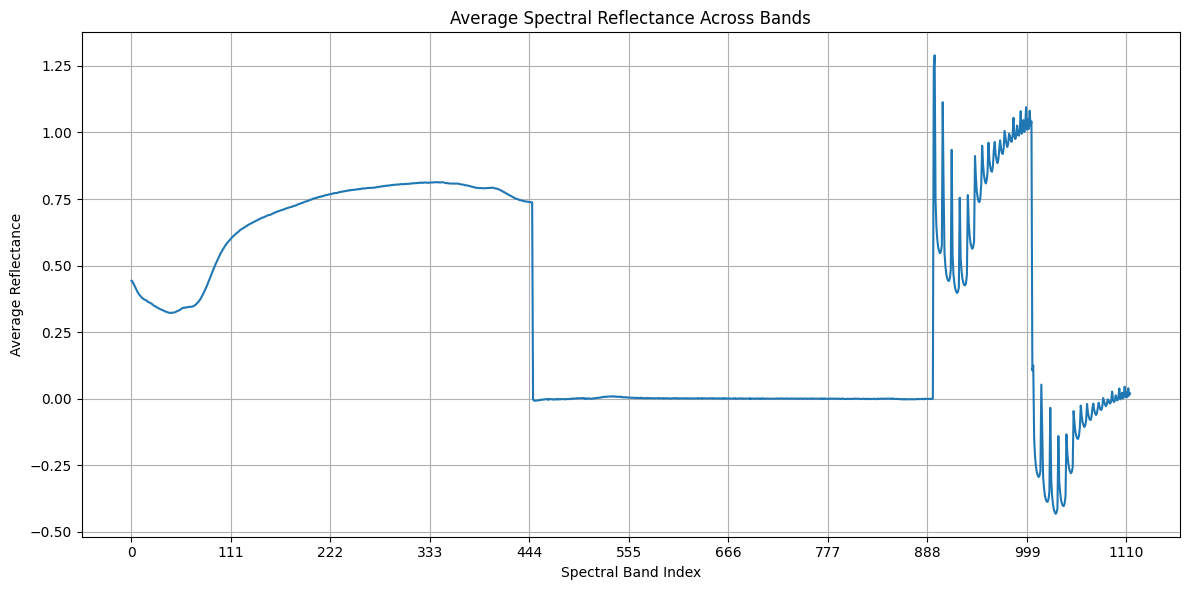

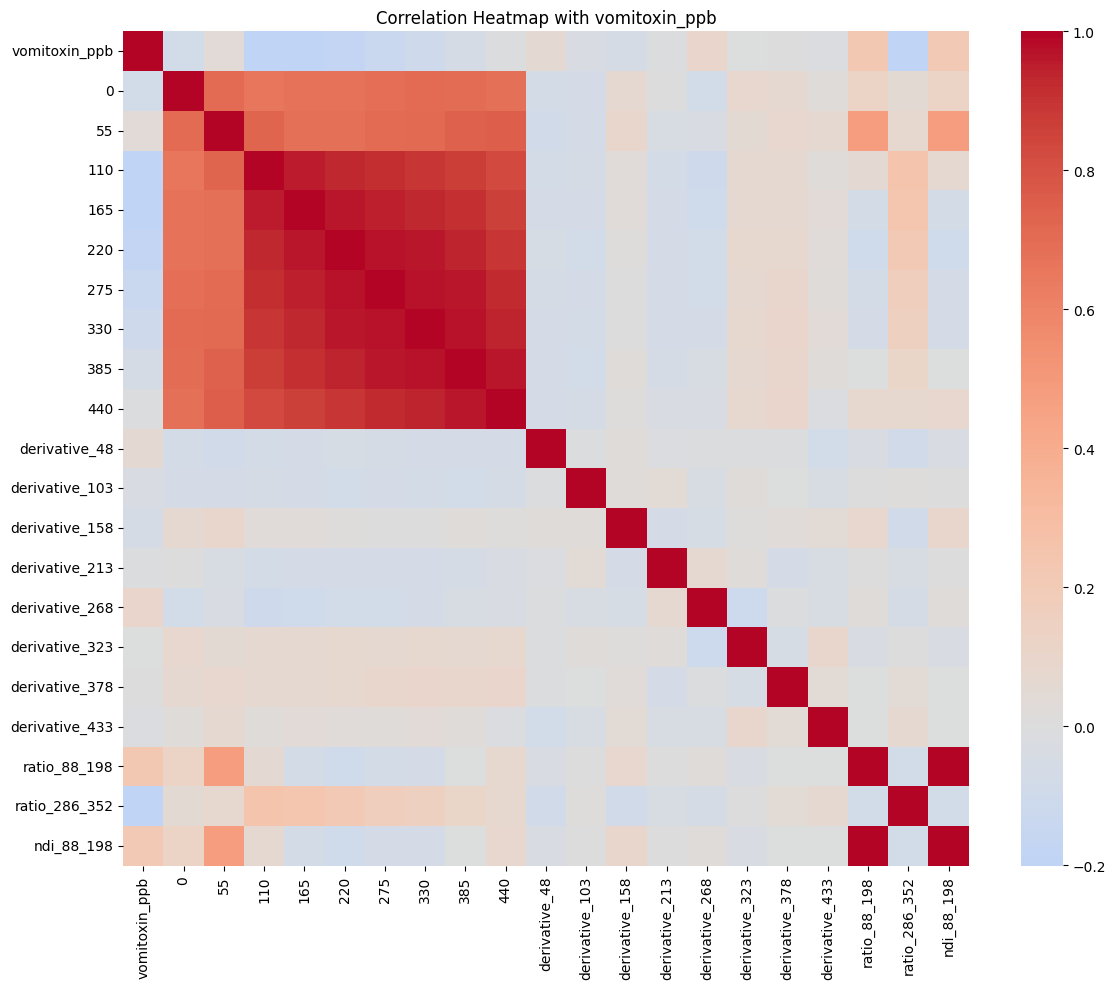

In [17]:
# Plot initial visualizations
print("\nGenerating initial visualizations...")
plot_spectral_reflectance(df, 'vomitoxin_ppb')
create_heatmap(df, 'vomitoxin_ppb')

In [18]:
# Handle outliers
print("\nHandling outliers...")
spectral_cols = [col for col in df.columns if col != 'vomitoxin_ppb']
df_cleaned = handle_outliers(df, spectral_cols, method='iqr', threshold=3)


Handling outliers...
Processing 1115 numeric columns for outlier detection


In [19]:
# Transform target variable
print("\nTransforming target variable...")
df_cleaned['vomitoxin_ppb'] = transform_target_variable(df_cleaned['vomitoxin_ppb'], method='log')


Transforming target variable...


In [20]:
# Normalize data
print("\nNormalizing data...")
X_normalized, y, scaler = normalize_data(df_cleaned, 'vomitoxin_ppb', method='robust')


Normalizing data...


In [21]:
# Split data
print("\nSplitting data into train/validation/test sets...")
X_train, X_test, y_train, y_test = split_data(X_normalized, y, test_size=0.2)
X_train, X_val, y_train, y_val = split_data(X_train, y_train, test_size=0.2)

print("\nData split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Splitting data into train/validation/test sets...

Data split sizes:
Training set: 320 samples
Validation set: 80 samples
Test set: 100 samples


# Dimensionality_Reduction

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def perform_pca(X, n_components=None, explained_variance_threshold=0.95):
    """
    Perform Principal Component Analysis on the data.
    
    Args:
        X (np.array): Feature matrix
        n_components (int, optional): Number of components to keep
        explained_variance_threshold (float): Threshold for cumulative explained variance
        
    Returns:
        tuple: (X_pca, pca, explained_variance_ratio, cumulative_variance)
    """
    if n_components is None:
        pca = PCA()
        X_pca = pca.fit_transform(X)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
    else:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
    
    return X_pca, pca, pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)

In [23]:
def plot_pca_variance(explained_variance_ratio, cumulative_variance):
    """
    Plot explained variance ratio and cumulative variance for PCA.
    
    Args:
        explained_variance_ratio (np.array): Explained variance ratio for each component
        cumulative_variance (np.array): Cumulative explained variance
    """
    plt.figure(figsize=(12, 5))
    
    # Plot individual explained variance
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Component')
    plt.grid(True, alpha=0.3)
    
    # Plot cumulative explained variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('results/pca_variance_explained.png')
    plt.show()

In [24]:
def analyze_feature_importance(pca, feature_names=None):
    """
    Analyze feature importance based on PCA loadings.
    
    Args:
        pca (PCA): Fitted PCA object
        feature_names (list): List of feature names
    """
    # Safety check for feature names length
    if feature_names is None or len(feature_names) != pca.components_.shape[1]:
        print(f"Warning: Feature names don't match PCA components shape. Using generic names.")
        feature_names = [f'Feature_{i}' for i in range(pca.components_.shape[1])]
    
    # Get absolute loadings for top components
    n_components = min(5, pca.components_.shape[0])
    loadings = pd.DataFrame(
        data=pca.components_[:n_components, :].T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # Calculate total importance across components
    loadings['Total_Importance'] = loadings.abs().sum(axis=1)
    loadings = loadings.sort_values('Total_Importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_names))
    top_features = loadings.head(top_n).index
    
    # Heatmap of loadings
    plt.subplot(1, 2, 1)
    sns.heatmap(loadings.loc[top_features, [f'PC{i+1}' for i in range(n_components)]],
                cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title(f'PCA Loadings for Top {top_n} Features')
    
    # Bar plot of total importance
    plt.subplot(1, 2, 2)
    loadings.loc[top_features, 'Total_Importance'].sort_values().plot(kind='barh')
    plt.title('Feature Importance Based on PCA Loadings')
    plt.xlabel('Total Absolute Loading')
    
    plt.tight_layout()
    plt.savefig('results/pca_feature_importance.png')
    plt.show()
    
    return loadings

In [25]:
def perform_tsne(X, n_components=2, perplexity=30, learning_rate=200, random_state=42):
    """
    Perform t-SNE dimensionality reduction.
    
    Args:
        X (np.array): Feature matrix
        n_components (int): Number of components for t-SNE
        perplexity (float): Perplexity parameter for t-SNE
        learning_rate (float): Learning rate for t-SNE
        random_state (int): Random seed for reproducibility
        
    Returns:
        np.array: Transformed data
    """
    print(f"Performing t-SNE with {n_components} components, perplexity={perplexity}")
    tsne = TSNE(
        n_components=n_components, 
        perplexity=perplexity, 
        learning_rate=learning_rate,
        random_state=random_state
    )
    X_tsne = tsne.fit_transform(X)
    return X_tsne

In [26]:
def analyze_tsne_clusters(X_tsne, y, max_clusters=10):
    """
    Analyze clustering patterns in t-SNE results.
    
    Args:
        X_tsne (np.array): t-SNE transformed data
        y (np.array): Target values
        max_clusters (int): Maximum number of clusters to try
        
    Returns:
        tuple: (optimal_n_clusters, silhouette_scores)
    """
    silhouette_scores = []
    
    # Try different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_tsne)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_tsne, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")
    
    # Find optimal number of clusters
    optimal_n_clusters = np.argmax(silhouette_scores) + 2  # +2 because we start from 2 clusters
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.axvline(x=optimal_n_clusters, color='r', linestyle='--', 
                label=f'Optimal clusters: {optimal_n_clusters}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('results/tsne_cluster_analysis.png')
    plt.show()
    
    return optimal_n_clusters, silhouette_scores

In [27]:
def plot_tsne_2d(X_tsne, y, title='t-SNE Visualization (2D)', cluster=False, n_clusters=None):
    """
    Plot 2D t-SNE results with color coding based on target values.
    
    Args:
        X_tsne (np.array): t-SNE transformed data
        y (np.array): Target values
        title (str): Plot title
        cluster (bool): Whether to perform clustering
        n_clusters (int): Number of clusters for KMeans
    """
    plt.figure(figsize=(12, 10))
    
    if cluster and n_clusters is not None:
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_tsne)
        
        # Plot with cluster colors
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10')
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title(f'{title} - Clusters')
        
        # Plot with target values
        plt.subplot(1, 2, 2)
    
    # Plot with target values
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter, label='Target Value')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/tsne_2d_visualization.png')
    plt.show()

In [28]:
def plot_tsne_3d(X_tsne, y, title='t-SNE Visualization (3D)'):
    """
    Plot 3D t-SNE results with color coding based on target values.
    
    Args:
        X_tsne (np.array): t-SNE transformed data with 3 components
        y (np.array): Target values
        title (str): Plot title
    """
    if X_tsne.shape[1] < 3:
        print("Error: 3D visualization requires 3 t-SNE components")
        return
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
        c=y, cmap='viridis', s=50, alpha=0.8
    )
    
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.set_title(title)
    
    fig.colorbar(scatter, ax=ax, label='Target Value')
    plt.savefig('results/tsne_3d_visualization.png')
    plt.show()

In [29]:
def plot_pca_components(X_pca, y, components=[0, 1], title='PCA Components Visualization'):
    """
    Plot PCA components with color coding based on target values.
    
    Args:
        X_pca (np.array): PCA transformed data
        y (np.array): Target values
        components (list): List of component indices to plot
        title (str): Plot title
    """
    if len(components) == 2:
        # 2D plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            X_pca[:, components[0]], X_pca[:, components[1]],
            c=y, cmap='viridis', alpha=0.8
        )
        plt.colorbar(scatter, label='Target Value')
        plt.xlabel(f'Principal Component {components[0]+1}')
        plt.ylabel(f'Principal Component {components[1]+1}')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.savefig('results/pca_2d_visualization.png')
        plt.show()
    
    elif len(components) == 3:
        # 3D plot
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(
            X_pca[:, components[0]], X_pca[:, components[1]], X_pca[:, components[2]],
            c=y, cmap='viridis', s=50, alpha=0.8
        )
        
        ax.set_xlabel(f'Principal Component {components[0]+1}')
        ax.set_ylabel(f'Principal Component {components[1]+1}')
        ax.set_zlabel(f'Principal Component {components[2]+1}')
        ax.set_title(title)
        
        fig.colorbar(scatter, ax=ax, label='Target Value')
        plt.savefig('results/pca_3d_visualization.png')
        plt.show()

In [30]:
def analyze_dimensionality_reduction(X, y, feature_names=None, n_components_pca=None, n_components_tsne=2):
    """
    Perform comprehensive dimensionality reduction analysis.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Target values
        feature_names (list): List of feature names
        n_components_pca (int, optional): Number of components for PCA
        n_components_tsne (int): Number of components for t-SNE
        
    Returns:
        tuple: (X_pca, X_tsne)
    """
    print("\n" + "="*50)
    print("DIMENSIONALITY REDUCTION ANALYSIS")
    print("="*50)
    
    # Create results directory if it doesn't exist
    import os
    os.makedirs('results', exist_ok=True)
    
    # PCA Analysis
    print("\nPerforming PCA analysis...")
    X_pca, pca, explained_variance_ratio, cumulative_variance = perform_pca(X, n_components_pca)
    
    # Report variance explained
    print("\nVariance explained by principal components:")
    for i, var in enumerate(explained_variance_ratio):
        print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")
    
    # Plot variance explained
    plot_pca_variance(explained_variance_ratio, cumulative_variance)
    
    # Analyze feature importance
    if feature_names is not None:
        print("\nAnalyzing feature importance based on PCA loadings...")
        feature_importance = analyze_feature_importance(pca, feature_names)
        
        # Print top 10 important features
        print("\nTop 10 important features based on PCA loadings:")
        for i, (feature, importance) in enumerate(
            feature_importance['Total_Importance'].head(10).items()
        ):
            print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Visualize PCA components
    print("\nVisualizing PCA components...")
    plot_pca_components(X_pca, y, components=[0, 1], 
                       title='First Two Principal Components')
    
    if X_pca.shape[1] >= 3:
        plot_pca_components(X_pca, y, components=[0, 1, 2], 
                           title='First Three Principal Components')
    
    # t-SNE Analysis
    print("\nPerforming t-SNE analysis...")
    X_tsne_2d = perform_tsne(X, n_components=2, perplexity=30)
    
    # Analyze clustering patterns
    print("\nAnalyzing clustering patterns in t-SNE results...")
    optimal_clusters, _ = analyze_tsne_clusters(X_tsne_2d, y)
    
    # Visualize t-SNE results
    print("\nVisualizing t-SNE results...")
    plot_tsne_2d(X_tsne_2d, y, cluster=True, n_clusters=optimal_clusters)
    
    # 3D t-SNE if requested
    if n_components_tsne == 3:
        print("\nPerforming 3D t-SNE analysis...")
        X_tsne_3d = perform_tsne(X, n_components=3, perplexity=30)
        plot_tsne_3d(X_tsne_3d, y)
        return X_pca, X_tsne_3d
    
    return X_pca, X_tsne_2d 


Performing dimensionality reduction analysis...
Number of features in X_normalized: 1115
Number of feature names: 1115

DIMENSIONALITY REDUCTION ANALYSIS

Performing PCA analysis...

Variance explained by principal components:
PC1: 0.3346 (0.3346 cumulative)
PC2: 0.0862 (0.4208 cumulative)
PC3: 0.0546 (0.4755 cumulative)
PC4: 0.0262 (0.5017 cumulative)
PC5: 0.0126 (0.5143 cumulative)
PC6: 0.0104 (0.5247 cumulative)
PC7: 0.0088 (0.5335 cumulative)
PC8: 0.0087 (0.5423 cumulative)
PC9: 0.0082 (0.5504 cumulative)
PC10: 0.0079 (0.5583 cumulative)


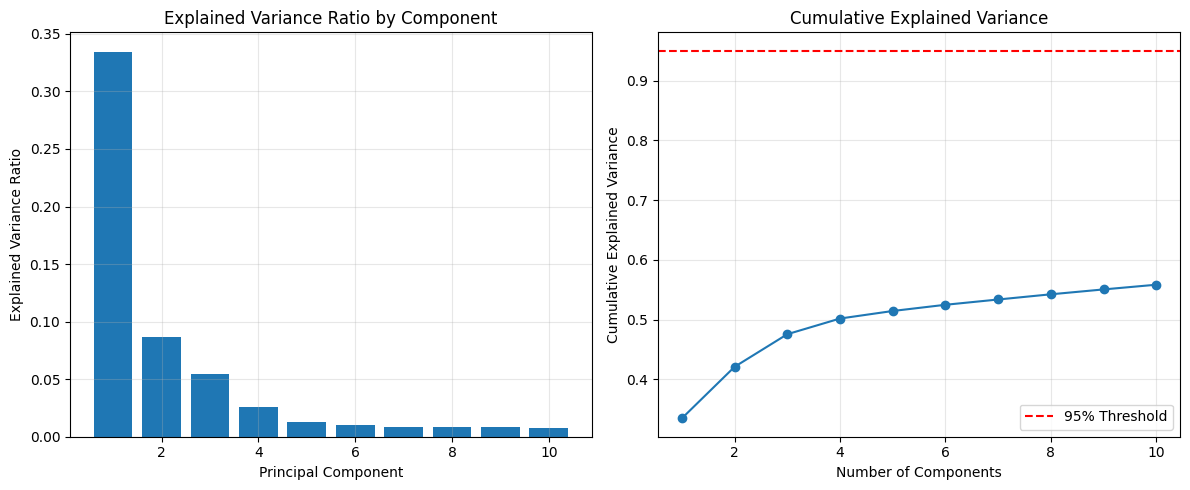


Analyzing feature importance based on PCA loadings...


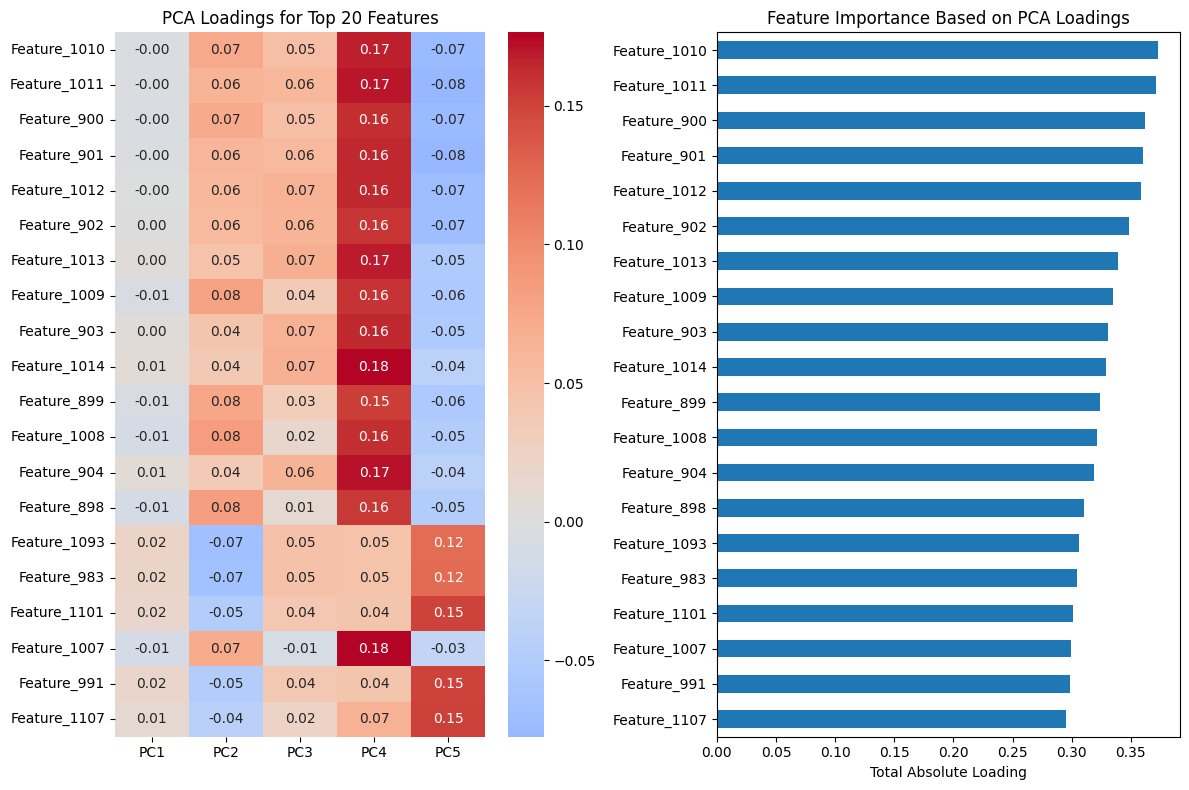


Top 10 important features based on PCA loadings:
1. Feature_1010: 0.3729
2. Feature_1011: 0.3709
3. Feature_900: 0.3620
4. Feature_901: 0.3600
5. Feature_1012: 0.3583
6. Feature_902: 0.3488
7. Feature_1013: 0.3391
8. Feature_1009: 0.3347
9. Feature_903: 0.3304
10. Feature_1014: 0.3287

Visualizing PCA components...


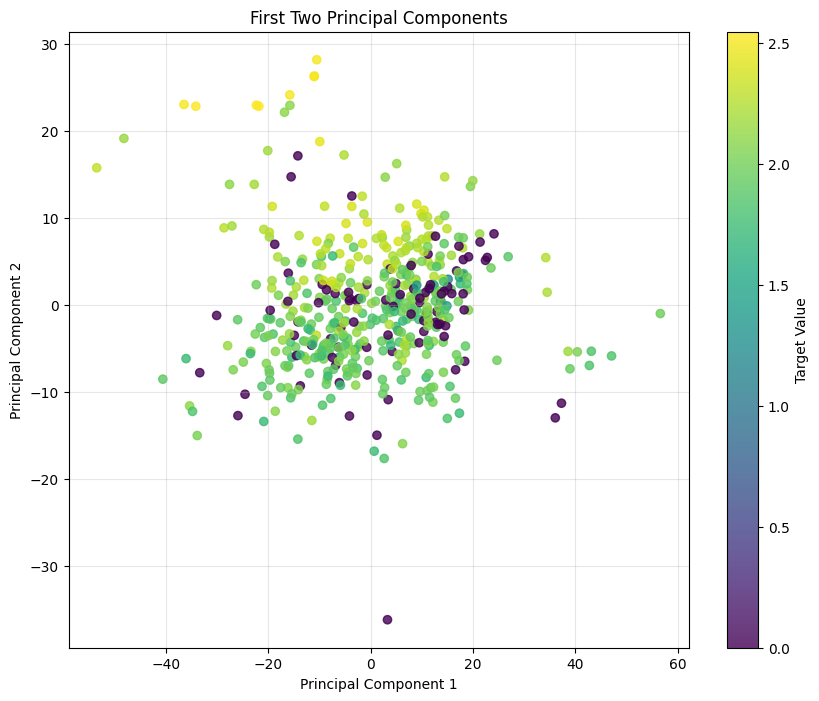

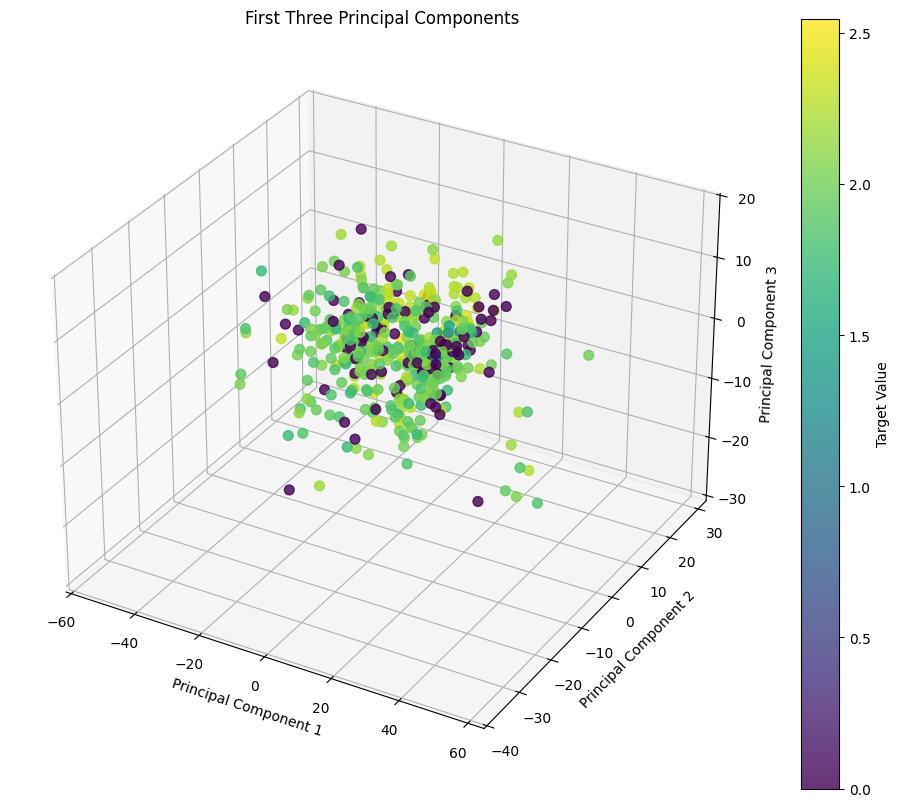


Performing t-SNE analysis...
Performing t-SNE with 2 components, perplexity=30

Analyzing clustering patterns in t-SNE results...
For n_clusters = 2, the silhouette score is 0.594
For n_clusters = 3, the silhouette score is 0.426
For n_clusters = 4, the silhouette score is 0.367
For n_clusters = 5, the silhouette score is 0.369
For n_clusters = 6, the silhouette score is 0.367
For n_clusters = 7, the silhouette score is 0.360
For n_clusters = 8, the silhouette score is 0.387
For n_clusters = 9, the silhouette score is 0.376
For n_clusters = 10, the silhouette score is 0.383


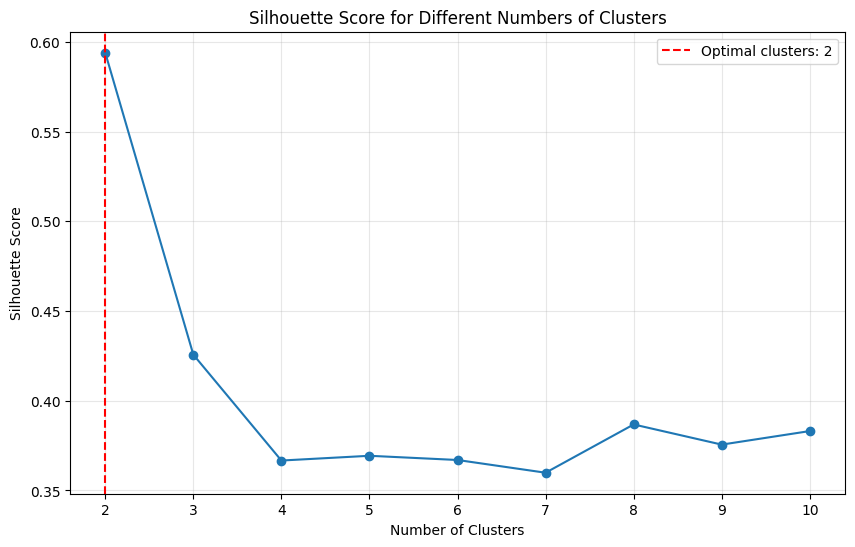


Visualizing t-SNE results...


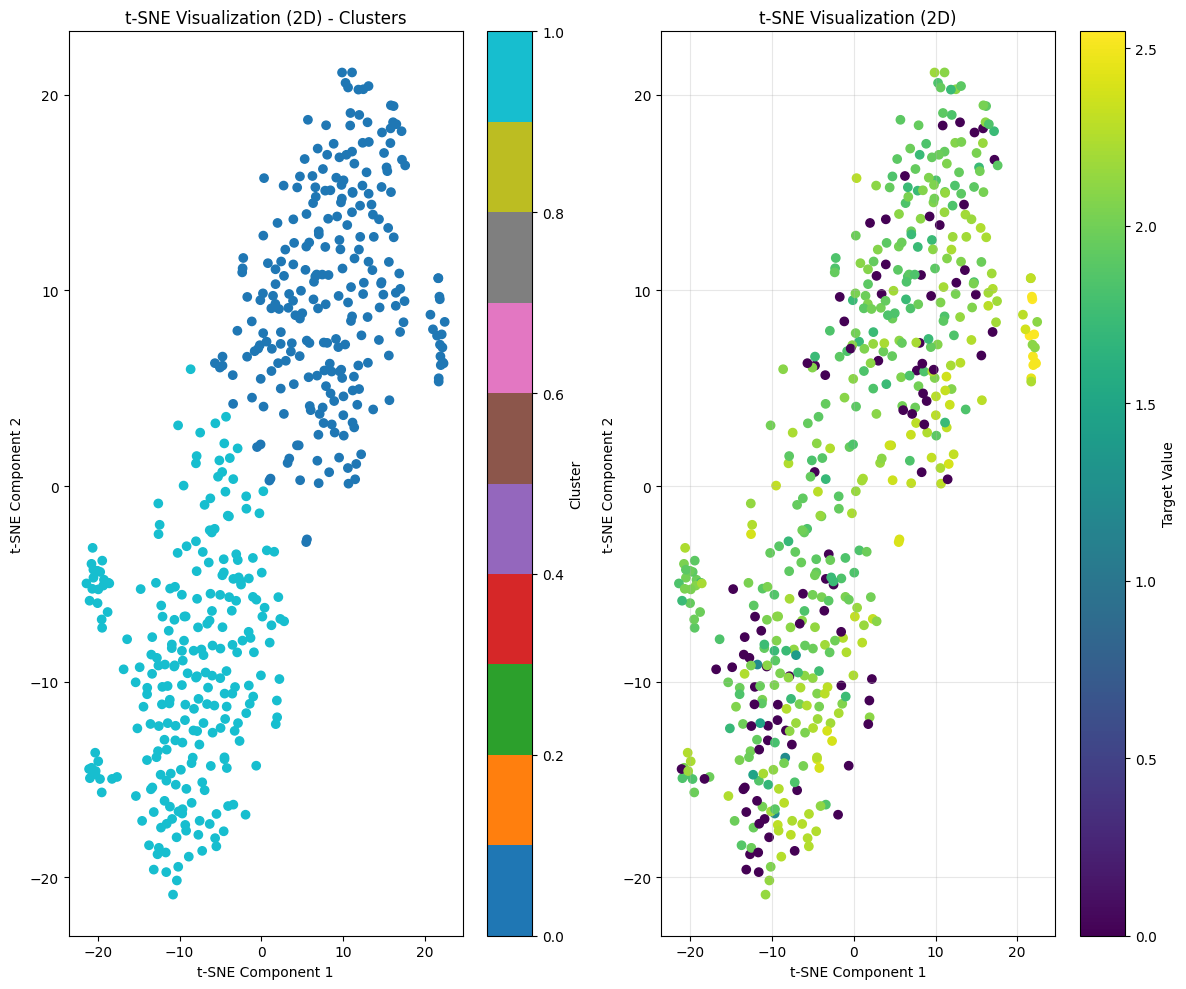


Performing 3D t-SNE analysis...
Performing t-SNE with 3 components, perplexity=30


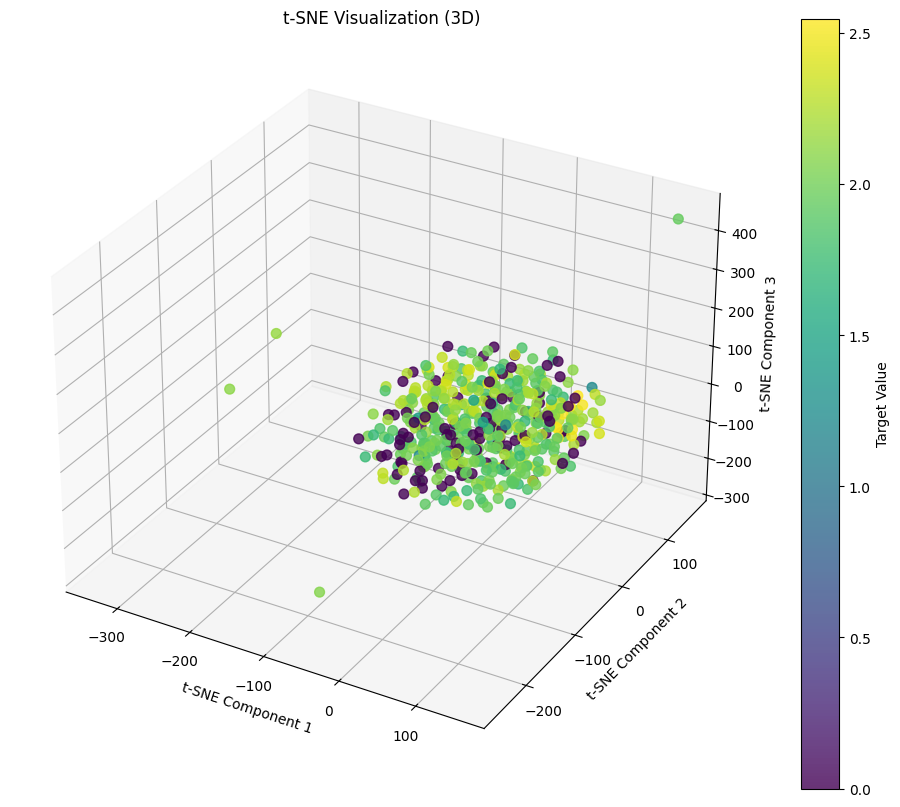

In [31]:
# Dimensionality reduction
print("\nPerforming dimensionality reduction analysis...")

# Fix: Ensure feature_names matches the shape of X_normalized
if isinstance(X_normalized, np.ndarray):
    # If X_normalized is numpy array, create generic feature names
    feature_names = [f'Feature_{i}' for i in range(X_normalized.shape[1])]
else:
    # For pandas DataFrame, use actual column names
    feature_names = list(X_normalized.columns)

# Validate feature names length
print(f"Number of features in X_normalized: {X_normalized.shape[1]}")
print(f"Number of feature names: {len(feature_names)}")

# Ensure the lengths match
if len(feature_names) != X_normalized.shape[1]:
    print("Warning: Feature names length doesn't match data dimensions.")
    feature_names = [f'Feature_{i}' for i in range(X_normalized.shape[1])]

# Perform comprehensive dimensionality reduction analysis
X_pca, X_tsne = analyze_dimensionality_reduction(
    X_normalized, 
    y, 
    feature_names=feature_names,
    n_components_pca=10,  # Keep top 10 components for PCA
    n_components_tsne=3   # Use 3D t-SNE for better visualization
)

# Save dimensionality reduction results
os.makedirs('results', exist_ok=True)
np.save('results/X_pca.npy', X_pca)
np.save('results/X_tsne.npy', X_tsne)


# Use PCA-transformed data for modeling if desired
# Uncomment the following lines to use PCA-reduced data
# X_train_pca, X_test_pca, y_train, y_test = split_data(X_pca, y, test_size=0.2)
# X_train_pca, X_val_pca, y_train, y_val = split_data(X_train_pca, y_train, test_size=0.2)
# X_train, X_val, X_test = X_train_pca, X_val_pca, X_test_pca

# Model Training

In [122]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)

In [145]:
def build_nn_model(input_shape, hidden_layers=128, num_layers=2, dropout_rate=0.2, learning_rate=0.001):
    """
    Build a basic neural network model for spectral data.
    
    Args:
        input_shape (tuple): Shape of input data
        hidden_layers (int): Number of units in hidden layers
        num_layers (int): Number of hidden layers
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for optimizer
        
    Returns:
        model: Compiled neural network model
    """
    class NNModel(nn.Module):
        """Neural Network model for spectral data."""
        def __init__(self, input_shape, hidden_layers=128, num_layers=2, dropout_rate=0.2, learning_rate=0.001):
            super(NNModel, self).__init__()
            
            # Save parameters
            self.input_shape = input_shape
            self.learning_rate = learning_rate
            
            # Create layers list
            self.hidden_layers = nn.ModuleList()
            self.dropout_layers = nn.ModuleList()
            
            # Input layer
            self.hidden_layers.append(nn.Linear(input_shape[0], hidden_layers))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            
            # Hidden layers
            for _ in range(num_layers - 1):
                self.hidden_layers.append(nn.Linear(hidden_layers, hidden_layers))
                self.dropout_layers.append(nn.Dropout(dropout_rate))
            
            # Output layer
            self.output_layer = nn.Linear(hidden_layers, 1)
            
            # Loss function and optimizer
            self.loss_fn = nn.MSELoss()
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        def forward(self, x):
            """Forward pass through the network."""
            # Process through all hidden layers
            for i, (layer, dropout) in enumerate(zip(self.hidden_layers, self.dropout_layers)):
                x = torch.relu(layer(x))
                x = dropout(x)
            
            # Output layer
            x = self.output_layer(x)
            
            return x
        
        def fit(self, X, y, epochs=50, batch_size=32, verbose=0, clip_grad=1.0):
            """
            Train the model.
            
            Args:
                X (numpy.ndarray): Training features
                y (numpy.ndarray): Training targets
                epochs (int): Number of epochs to train
                batch_size (int): Batch size for training
                verbose (int): Verbosity level
                clip_grad (float): Max norm for gradient clipping
            """
            # Convert pandas Series to numpy arrays if needed
            if isinstance(y, pd.Series):
                y = y.values
            
            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
            
            # Move to GPU if available
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.to(device)
            X_tensor = X_tensor.to(device)
            y_tensor = y_tensor.to(device)
            
            # Create dataset and dataloader
            dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
            # Training loop
            self.train()
            for epoch in range(epochs):
                epoch_loss = 0.0
                for batch_X, batch_y in dataloader:
                    # Zero gradients
                    self.optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = self(batch_X)
                    
                    # Calculate loss
                    loss = self.loss_fn(outputs, batch_y)
                    
                    # Backward pass and optimize
                    loss.backward()
                    
                    # Apply gradient clipping to prevent NaN values
                    torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                    
                    self.optimizer.step()
                    
                    epoch_loss += loss.item()
                
                if verbose > 0 and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
        
        def predict(self, X):
            """
            Make predictions with the model.
            
            Args:
                X (numpy.ndarray): Input features
                
            Returns:
                numpy.ndarray: Predictions
            """
            # Convert numpy array to PyTorch tensor
            X_tensor = torch.tensor(X, dtype=torch.float32)
            
            # Move to GPU if available
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.to(device)
            X_tensor = X_tensor.to(device)
            
            # Set model to evaluation mode
            self.eval()
            
            # Make predictions
            with torch.no_grad():
                predictions = self(X_tensor)
            
            # Convert to numpy array and handle potential NaN values
            predictions_np = predictions.cpu().numpy()
            if np.isnan(predictions_np).any():
                print("Warning: NaN values detected in predictions. Replacing with zeros.")
                predictions_np = np.nan_to_num(predictions_np, nan=0.0)
            
            return predictions_np
    
    # Create and return model
    model = NNModel(
        input_shape=input_shape,
        hidden_layers=hidden_layers,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    return model

In [150]:
def build_cnn_model(input_shape, filters=64, kernel_size=3, dense_layers=64, dropout_rate=0.2, learning_rate=0.001):
    """
    Build a CNN model for spectral data with proper dimension handling.
    
    Args:
        input_shape (tuple): Shape of input data
        filters (int): Number of filters in convolutional layers
        kernel_size (int): Size of convolutional kernels
        dense_layers (int): Number of units in dense layer
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for optimizer
        
    Returns:
        model: Compiled CNN model
    """
    class CNNModel(nn.Module):
        """CNN model for spectral data."""
        def __init__(self, input_shape, filters=64, kernel_size=3, dense_layers=64, dropout_rate=0.2, learning_rate=0.001):
            super(CNNModel, self).__init__()
            
            # Save parameters
            self.input_shape = input_shape
            self.learning_rate = learning_rate
            
            # Ensure kernel_size is appropriate
            kernel_size = min(kernel_size, input_shape[0] // 2)
            if kernel_size % 2 == 0:  # Make kernel size odd for symmetric padding
                kernel_size += 1
            
            # Calculate feature map size after pooling operations
            # After first pooling: input_shape[0] // 2
            # After second pooling: input_shape[0] // 4
            self.feature_map_size = input_shape[0] // 4
            
            # CNN layers
            self.conv1 = nn.Conv1d(1, filters, kernel_size=kernel_size, padding=kernel_size//2)
            self.pool1 = nn.MaxPool1d(2)
            self.dropout1 = nn.Dropout(dropout_rate)
            
            self.conv2 = nn.Conv1d(filters, filters*2, kernel_size=kernel_size, padding=kernel_size//2)
            self.pool2 = nn.MaxPool1d(2)
            self.dropout2 = nn.Dropout(dropout_rate)
            
            # Calculate CNN output size correctly
            self.cnn_output_size = self.feature_map_size * (filters * 2)
            
            # Dense layers
            self.dense = nn.Linear(self.cnn_output_size, dense_layers)
            self.dropout3 = nn.Dropout(dropout_rate)
            
            # Output layer
            self.output_layer = nn.Linear(dense_layers, 1)
            
            # Loss function and optimizer
            self.loss_fn = nn.MSELoss()
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        def forward(self, x):
            """Forward pass through the network with dimension checks."""
            batch_size = x.size(0)
            
            # Handle NaN values
            if torch.isnan(x).any():
                x = torch.nan_to_num(x, nan=0.0)
            
            # Reshape input for CNN: (batch, features) -> (batch, 1, seq_len)
            x = x.view(batch_size, 1, self.input_shape[0])
            
            # First CNN block
            x = torch.relu(self.conv1(x))
            x = self.pool1(x)
            x = self.dropout1(x)
            
            # Second CNN block
            x = torch.relu(self.conv2(x))
            x = self.pool2(x)
            x = self.dropout2(x)
            
            # Flatten tensor properly
            try:
                x = x.view(batch_size, -1)
            except RuntimeError:
                # Handle potential shape mismatch
                actual_size = x.size(1) * x.size(2)
                if actual_size != self.cnn_output_size:
                    # Reshape and either pad or truncate to match expected size
                    x = x.view(batch_size, -1)
                    if x.size(1) < self.cnn_output_size:
                        padding = torch.zeros(batch_size, self.cnn_output_size - x.size(1), device=x.device)
                        x = torch.cat([x, padding], dim=1)
                    else:
                        x = x[:, :self.cnn_output_size]
            
            # Dense layer
            x = torch.relu(self.dense(x))
            x = self.dropout3(x)
            
            # Output layer
            x = self.output_layer(x)
            
            # Replace any NaN outputs with zeros
            if torch.isnan(x).any():
                x = torch.nan_to_num(x, nan=0.0)
            
            return x
        
        def fit(self, X, y, epochs=50, batch_size=32, verbose=0, clip_grad=1.0):
            """
            Train the model with NaN handling.
            """
            # Convert pandas Series to numpy arrays if needed
            if isinstance(y, pd.Series):
                y = y.values
            
            # Handle NaN values in inputs
            if np.isnan(X).any():
                print("Warning: NaN values in X replaced with zeros.")
                X = np.nan_to_num(X, nan=0.0)
            
            if np.isnan(y).any():
                print("Warning: NaN values in y replaced with zeros.")
                y = np.nan_to_num(y, nan=0.0)
            
            # Convert numpy arrays to PyTorch tensors
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
            
            # Move to GPU if available
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.to(device)
            X_tensor = X_tensor.to(device)
            y_tensor = y_tensor.to(device)
            
            # Create dataset and dataloader
            dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
            # Training loop
            self.train()
            for epoch in range(epochs):
                epoch_loss = 0.0
                batch_count = 0
                
                for batch_X, batch_y in dataloader:
                    try:
                        # Zero gradients
                        self.optimizer.zero_grad()
                        
                        # Forward pass
                        outputs = self(batch_X)
                        
                        # Calculate loss
                        loss = self.loss_fn(outputs, batch_y)
                        
                        # Backward pass and optimize
                        loss.backward()
                        
                        # Apply gradient clipping to prevent NaN values
                        torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                        
                        self.optimizer.step()
                        
                        epoch_loss += loss.item()
                        batch_count += 1
                    except Exception as e:
                        print(f"Error in batch: {e}")
                        continue
                
                if verbose > 0 and (epoch + 1) % 10 == 0:
                    avg_loss = epoch_loss / max(1, batch_count)
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        
        def predict(self, X):
            """
            Make predictions with NaN handling.
            """
            # Handle NaN values
            if np.isnan(X).any():
                print("Warning: NaN values in input replaced with zeros.")
                X = np.nan_to_num(X, nan=0.0)
            
            # Convert numpy array to PyTorch tensor
            X_tensor = torch.tensor(X, dtype=torch.float32)
            
            # Move to GPU if available
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.to(device)
            X_tensor = X_tensor.to(device)
            
            # Set model to evaluation mode
            self.eval()
            
            # Make predictions
            with torch.no_grad():
                predictions = self(X_tensor)
            
            # Handle NaN values in predictions
            predictions_np = predictions.cpu().numpy()
            if np.isnan(predictions_np).any():
                print("Warning: NaN values in predictions replaced with zeros.")
                predictions_np = np.nan_to_num(predictions_np, nan=0.0)
            
            return predictions_np
    
    # Create and return model
    model = CNNModel(
        input_shape=input_shape,
        filters=filters,
        kernel_size=kernel_size,
        dense_layers=dense_layers,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    return model

In [125]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train the PyTorch model with early stopping.
    
    Args:
        model (torch.nn.Module): Model to train
        X_train (np.array): Training features
        y_train (np.array): Training labels
        X_val (np.array): Validation features
        y_val (np.array): Validation labels
        epochs (int): Maximum number of epochs
        batch_size (int): Batch size for training
        
    Returns:
        dict: Training history
    """
    # Convert pandas Series to numpy arrays if needed
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_val, pd.Series):
        y_val = y_val.values
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    # Move to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_val_tensor = X_val_tensor.to(device)
    y_val_tensor = y_val_tensor.to(device)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    
    # Training history
    history = {
        'loss': [],
        'val_loss': [],
        'mae': [],
        'val_mae': []
    }
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        # Training
        train_loss = 0.0
        train_mae = 0.0
        for batch_X, batch_y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item() * batch_X.size(0)
            train_mae += torch.sum(torch.abs(outputs - batch_y)).item()
        
        train_loss /= len(train_dataset)
        train_mae /= len(train_dataset)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_mae = torch.mean(torch.abs(val_outputs - y_val_tensor)).item()
        model.train()
        
        # Update history
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f}")
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return history

In [126]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the PyTorch model on test data.
    
    Args:
        model (torch.nn.Module): Trained model
        X_test (np.array): Test features
        y_test (np.array): Test labels
        
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Convert pandas Series to numpy array if needed
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    # Convert numpy arrays to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # Move to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred = model(X_test_tensor).cpu().numpy()
    
    # Calculate metrics
    metrics = {
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'r2': r2_score(y_test, y_pred)
    }
    
    return metrics

In [127]:
def plot_training_history(history):
    """
    Plot training and validation loss/MAE.
    
    Args:
        history (dict): Training history
    """
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [128]:
def plot_predictions(y_true, y_pred):
    """
    Plot actual vs predicted values.
    
    Args:
        y_true (np.array): True values
        y_pred (np.array): Predicted values
    """
    # Ensure y_pred is flattened if it's a 2D array
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show() 

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LSTMModel(nn.Module):
    """LSTM model for spectral data."""
    def __init__(self, input_shape, lstm_layers=[64, 32], dense_layers=[32], dropout_rate=0.2, learning_rate=0.001):
        super(LSTMModel, self).__init__()
        
        # Save parameters
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
        # LSTM layers
        self.lstm_layers = nn.ModuleList()
        
        # First LSTM layer takes input with shape (batch, seq_len, 1)
        self.lstm_layers.append(nn.LSTM(
            input_size=1,
            hidden_size=lstm_layers[0],
            batch_first=True
        ))
        
        # Add dropout after first layer
        self.lstm_dropouts = nn.ModuleList([nn.Dropout(dropout_rate)])
        
        # Add remaining LSTM layers
        for i in range(1, len(lstm_layers)):
            self.lstm_layers.append(nn.LSTM(
                input_size=lstm_layers[i-1],
                hidden_size=lstm_layers[i],
                batch_first=True
            ))
            self.lstm_dropouts.append(nn.Dropout(dropout_rate))
        
        # Dense layers
        self.dense_layers = nn.ModuleList()
        self.dense_dropouts = nn.ModuleList()
        
        # First dense layer takes input from last LSTM layer
        input_size = lstm_layers[-1]
        
        for units in dense_layers:
            self.dense_layers.append(nn.Linear(input_size, units))
            self.dense_dropouts.append(nn.Dropout(dropout_rate))
            input_size = units
        
        # Output layer
        self.output_layer = nn.Linear(input_size, 1)
        
        # Loss function and optimizer
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        """Forward pass through the network."""
        # Reshape input for LSTM: (batch, features) -> (batch, seq_len, 1)
        x = x.view(x.size(0), self.input_shape[0], 1)
        
        # Pass through LSTM layers
        for i, (lstm, dropout) in enumerate(zip(self.lstm_layers, self.lstm_dropouts)):
            # LSTM returns output and hidden state tuple (h_n, c_n)
            output, _ = lstm(x)
            
            # If it's the last LSTM layer, keep only the last time step
            if i == len(self.lstm_layers) - 1:
                x = output[:, -1, :]  # shape: (batch, hidden_size)
            else:
                x = dropout(output)
        
        # Pass through dense layers
        for dense, dropout in zip(self.dense_layers, self.dense_dropouts):
            x = torch.relu(dense(x))
            x = dropout(x)
        
        # Output layer
        x = self.output_layer(x)
        
        return x
    
    def fit(self, X, y, epochs=50, batch_size=32, verbose=0, clip_grad=None):
        """
        Train the model.
        
        Args:
            X (numpy.ndarray): Training features
            y (numpy.ndarray): Training targets
            epochs (int): Number of epochs to train
            batch_size (int): Batch size for training
            verbose (int): Verbosity level
            clip_grad (float): Max norm for gradient clipping (None to disable)
        """
        # Convert numpy arrays to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        
        # Move to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        X_tensor = X_tensor.to(device)
        y_tensor = y_tensor.to(device)
        
        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Training loop
        self.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                # Zero gradients
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self(batch_X)
                
                # Calculate loss
                loss = self.loss_fn(outputs, batch_y)
                
                # Backward pass and optimize
                loss.backward()
                
                # Apply gradient clipping if specified
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            if verbose > 0 and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
    
    def predict(self, X):
        """
        Make predictions with the model.
        
        Args:
            X (numpy.ndarray): Input features
            
        Returns:
            numpy.ndarray: Predictions
        """
        # Convert to PyTorch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Move to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        X_tensor = X_tensor.to(device)
        
        # Set model to evaluation mode
        self.eval()
        
        # Make predictions
        with torch.no_grad():
            y_pred = self(X_tensor)
        
        # Return as numpy array
        return y_pred.cpu().numpy()


In [130]:
class AttentionLayer(nn.Module):
    """Attention mechanism layer."""
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        # Calculate attention weights
        attention_weights = self.attention(x)  # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)  # (batch, seq_len, 1)
        
        # Apply attention weights
        context_vector = torch.sum(x * attention_weights, dim=1)  # (batch, input_dim)
        
        return context_vector

In [131]:
class AttentionModel(nn.Module):
    """Model with attention mechanism."""
    def __init__(self, input_shape, lstm_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
        """
        Initialize attention model.
        
        Args:
            input_shape (tuple): Shape of input data
            lstm_units (int): Number of LSTM units
            dense_units (int): Number of dense layer units
            dropout_rate (float): Dropout rate for regularization
            learning_rate (float): Learning rate for optimizer
        """
        super(AttentionModel, self).__init__()
        
        # Save parameters
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        
        # LSTM layer - REMOVE return_sequences parameter
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=lstm_units,
            batch_first=True
            # Remove return_sequences=True - PyTorch always returns sequences by default
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Attention mechanism
        self.attention = AttentionLayer(lstm_units)
        
        # Dense layers
        self.dense = nn.Linear(lstm_units, dense_units)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.output_layer = nn.Linear(dense_units, 1)
        
        # Loss function and optimizer
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        """Forward pass through the network."""
        # Reshape input for LSTM: (batch, features) -> (batch, seq_len, 1)
        x = x.view(x.size(0), self.input_shape[0], 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_len, lstm_units)
        lstm_out = self.dropout1(lstm_out)
        
        # Attention mechanism
        context_vector = self.attention(lstm_out)
        
        # Dense layer
        x = torch.relu(self.dense(context_vector))
        x = self.dropout2(x)
        
        # Output layer
        x = self.output_layer(x)
        
        return x
    
    def fit(self, X, y, epochs=50, batch_size=32, verbose=0, clip_grad=None):
        """
        Train the model.
        
        Args:
            X (numpy.ndarray): Training features
            y (numpy.ndarray): Training targets
            epochs (int): Number of epochs to train
            batch_size (int): Batch size for training
            verbose (int): Verbosity level
            clip_grad (float): Max norm for gradient clipping (None to disable)
        """
        # Convert numpy arrays to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        
        # Move to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        X_tensor = X_tensor.to(device)
        y_tensor = y_tensor.to(device)
        
        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Training loop
        self.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                # Zero gradients
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self(batch_X)
                
                # Calculate loss
                loss = self.loss_fn(outputs, batch_y)
                
                # Backward pass and optimize
                loss.backward()
                
                # Apply gradient clipping if specified
                if clip_grad is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            if verbose > 0 and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
    
    def predict(self, X):
        """
        Make predictions with the model.
        
        Args:
            X (numpy.ndarray): Input features
            
        Returns:
            numpy.ndarray: Predictions
        """
        # Convert to PyTorch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Move to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        X_tensor = X_tensor.to(device)
        
        # Set model to evaluation mode
        self.eval()
        
        # Make predictions
        with torch.no_grad():
            y_pred = self(X_tensor)
        
        # Return as numpy array
        return y_pred.cpu().numpy()


In [134]:
# Factory functions to maintain compatibility with the original API
def build_lstm_model(input_shape, lstm_layers=[64, 32], dense_layers=[32], dropout_rate=0.2, learning_rate=0.001):
    """Factory function to create an LSTM model."""
    return LSTMModel(input_shape, lstm_layers, dense_layers, dropout_rate, learning_rate)

def build_attention_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    """Factory function to create an attention model."""
    return AttentionModel(input_shape, lstm_units, dense_units, dropout_rate, learning_rate)

# Hyperparameter Optimization

In [135]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
import torch

class BayesianOptimization:
    def __init__(self, param_ranges, n_initial_points=5):
        """
        Initialize Bayesian Optimization.
        
        Args:
            param_ranges (dict): Dictionary of parameter ranges
            n_initial_points (int): Number of initial random points
        """
        self.param_ranges = param_ranges
        self.n_initial_points = n_initial_points
        self.X = []
        self.y = []
        self.gp = GaussianProcessRegressor(
            kernel=Matern(nu=2.5),
            normalize_y=True,
            n_restarts_optimizer=10,
            random_state=42
        )
    
    def _random_point(self):
        """Generate a random point in the parameter space."""
        point = {}
        for param, param_range in self.param_ranges.items():
            min_val, max_val = param_range
            if isinstance(min_val, int):
                point[param] = np.random.randint(min_val, max_val + 1)
            else:
                point[param] = np.random.uniform(min_val, max_val)
        return point

    
    def _point_to_array(self, point):
        """Convert parameter dictionary to array."""
        return np.array([point[param] for param in self.param_ranges.keys()])
    
    def _array_to_point(self, array):
        """Convert array to parameter dictionary."""
        return {param: val for param, val in zip(self.param_ranges.keys(), array)}
    
    def _acquisition_function(self, X_candidates):
        """Calculate acquisition function (Expected Improvement)."""
        if len(self.X) < 2:
            return np.zeros(len(X_candidates))
        
        X = np.array(self.X)
        y = np.array(self.y)
        
        # Fit GP
        self.gp.fit(X, y)
        
        # Get predictions
        mu, sigma = self.gp.predict(X_candidates, return_std=True)
        
        # Calculate Expected Improvement
        best_f = np.max(y)
        z = (mu - best_f) / (sigma + 1e-9)
        ei = (mu - best_f) * norm.cdf(z) + sigma * norm.pdf(z)
        
        return ei
    
    def suggest_next_point(self):
        """Suggest the next point to evaluate."""
        if len(self.X) < self.n_initial_points:
            return self._random_point()
        
        # Generate candidate points
        n_candidates = 1000
        X_candidates = np.array([self._random_point() for _ in range(n_candidates)])
        X_candidates = np.array([self._point_to_array(point) for point in X_candidates])
        
        # Calculate acquisition function
        ei = self._acquisition_function(X_candidates)
        
        # Select best candidate
        best_idx = np.argmax(ei)
        return self._array_to_point(X_candidates[best_idx])
    
    def update(self, point, score):
        """Update the optimization with a new observation."""
        self.X.append(self._point_to_array(point))
        self.y.append(score)
    
    def get_best_point(self):
        """Get the best point found so far."""
        if not self.X:
            return None, None
        
        best_idx = np.argmax(self.y)
        return self._array_to_point(self.X[best_idx]), self.y[best_idx]

In [138]:
def optimize_hyperparameters(model_fn, param_ranges, X_train, y_train, n_trials=20):
    """
    Optimize hyperparameters using Bayesian Optimization.
    
    Args:
        model_fn (function): Function to create and train model
        param_ranges (dict): Dictionary of parameter ranges
        X_train (np.array): Training features
        y_train (np.array): Training labels
        n_trials (int): Number of optimization trials
        
    Returns:
        dict: Best hyperparameters found
    """
    optimizer = BayesianOptimization(param_ranges)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Convert pandas Series/DataFrame to numpy arrays if needed
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    
    # Check if CUDA is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Check for NaN values in input data
    if np.isnan(X_train_np).any() or np.isnan(y_train_np).any():
        print("Warning: Input data contains NaN values. Replacing with zeros.")
        X_train_np = np.nan_to_num(X_train_np, nan=0.0)
        y_train_np = np.nan_to_num(y_train_np, nan=0.0)
    
    for trial in range(n_trials):
        # Get next point to evaluate
        params = optimizer.suggest_next_point()
        
        # Cross-validation score
        cv_scores = []
        for train_idx, val_idx in kf.split(X_train_np):
            try:
                X_fold_train = X_train_np[train_idx]
                y_fold_train = y_train_np[train_idx]
                X_fold_val = X_train_np[val_idx]
                y_fold_val = y_train_np[val_idx]
                
                # Train and evaluate model
                model = model_fn(params)
                model.to(device)  # Move model to GPU if available
                
                # Train model with gradient clipping to prevent NaN
                model.train()
                model.fit(X_fold_train, y_fold_train, epochs=50, batch_size=32, verbose=0, clip_grad=1.0)
                
                # Evaluate model with NaN handling
                model.eval()
                y_pred = model.predict(X_fold_val)
                
                # Handle NaN in predictions
                if np.isnan(y_pred).any():
                    print(f"Warning: NaN values in predictions for trial {trial+1}. Replacing with zeros.")
                    y_pred = np.nan_to_num(y_pred, nan=0.0)
                
                score = -mean_squared_error(y_fold_val, y_pred)  # Negative MSE for maximization
                cv_scores.append(score)
            except Exception as e:
                print(f"Error in fold: {str(e)}")
                # Assign a very poor score for this fold
                cv_scores.append(-float('inf'))
        
        # Update optimizer if we have valid scores
        if cv_scores:
            mean_score = np.mean([s for s in cv_scores if s != -float('inf')])
            # If all scores are invalid, assign a poor but finite score
            if mean_score == -float('inf'):
                mean_score = -1e6
            optimizer.update(params, mean_score)
        
        print(f"Trial {trial + 1}/{n_trials}")
        print(f"Parameters: {params}")
        print(f"Cross-validation score: {mean_score:.4f}")
    
    # Get best parameters
    best_params, best_score = optimizer.get_best_point()
    print("\nBest parameters found:")
    print(best_params)
    print(f"Best cross-validation score: {best_score:.4f}")
    
    return best_params

In [154]:
LSTM_PARAM_RANGES = {
    'lstm_layers': (32, 256),      # Number of units in first LSTM layer
    'dense_layers': (16, 128),     # Number of units in dense layer
    'dropout_rate': (0.1, 0.5),    # Dropout rate
    'learning_rate': (1e-4, 1e-2)  # Learning rate
}

ATTENTION_PARAM_RANGES = {
    'lstm_units': (32, 256),       # Number of LSTM units
    'dense_units': (16, 128),      # Number of dense layer units
    'dropout_rate': (0.1, 0.5),    # Dropout rate
    'learning_rate': (1e-4, 1e-2)  # Learning rate
}

# CNN parameter ranges
CNN_PARAM_RANGES = {
    'filters': (16, 128),  # Number of filters in convolutional layers
    'kernel_size': (3, 7),  # Size of convolutional kernels
    'dense_layers': (32, 128),  # Size of dense layers
    'dropout_rate': (0.1, 0.5),  # Dropout rate for regularization
    'learning_rate': (0.0001, 0.001)  # Learning rate for optimizer
}

# Neural Network parameter ranges
NN_PARAM_RANGES = {
    'hidden_layers': (32, 256),  # Size of hidden layers
    'num_layers': (1, 4),  # Number of hidden layers
    'dropout_rate': (0.1, 0.5),  # Dropout rate for regularization 
    'learning_rate': (0.0001, 0.001)  # Learning rate for optimizer
}

## 1. LSTM

In [100]:
# Optimize and train models
print("\nOptimizing and training models...")

# LSTM Model
print("\nOptimizing LSTM model...")
def create_lstm(params):
    return build_lstm_model(
        input_shape=(X_train.shape[1],),
        lstm_layers=[int(params['lstm_layers']), int(params['lstm_layers'])//2],
        dense_layers=[int(params['dense_layers'])],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

lstm_params = optimize_hyperparameters(
    create_lstm, LSTM_PARAM_RANGES, X_train, y_train, n_trials=20
)

print("\nTraining LSTM model with optimized parameters...")
lstm_model = create_lstm(lstm_params)
lstm_history = train_model(lstm_model, X_train, y_train, X_val, y_val, epochs=100)
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)
print("\nLSTM Model Metrics:")
print(lstm_metrics)
plot_training_history(lstm_history)
plot_predictions(y_test, lstm_model.predict(X_test))


Optimizing and training models...

Optimizing LSTM model...
Using device: cuda:0
Trial 1/20
Parameters: {'lstm_layers': 65, 'dense_layers': 115, 'dropout_rate': 0.34602933600740426, 'learning_rate': 0.00159284887674028}
Cross-validation score: -0.6623
Trial 2/20
Parameters: {'lstm_layers': 243, 'dense_layers': 87, 'dropout_rate': 0.47436223412792644, 'learning_rate': 0.0014559547257120189}
Cross-validation score: -0.6811
Trial 3/20
Parameters: {'lstm_layers': 47, 'dense_layers': 90, 'dropout_rate': 0.40082374738014737, 'learning_rate': 0.0005524777639220163}
Cross-validation score: -0.6428
Trial 4/20
Parameters: {'lstm_layers': 49, 'dense_layers': 50, 'dropout_rate': 0.4508109085046549, 'learning_rate': 0.0018916333333822229}
Cross-validation score: -0.6683
Trial 5/20
Parameters: {'lstm_layers': 250, 'dense_layers': 74, 'dropout_rate': 0.34395749666771974, 'learning_rate': 0.004126568629343575}
Cross-validation score: -0.6895
Trial 6/20
Parameters: {'lstm_layers': np.float64(34.0), 'd

ValueError: could not determine the shape of object type 'Series'

## Best parameters found:
{'lstm_layers': np.float64(47.0), 'dense_layers': np.float64(90.0), 'dropout_rate': np.float64(0.40082374738014737), 'learning_rate': np.float64(0.0005524777639220163)}
Best cross-validation score: -0.6428


Training LSTM model with pre-optimized parameters...

Training LSTM model with optimized parameters...
Epoch 10/100, Loss: 0.7289, Val Loss: 0.5367, MAE: 0.6691, Val MAE: 0.5407
Epoch 20/100, Loss: 0.6933, Val Loss: 0.4599, MAE: 0.6488, Val MAE: 0.4879
Epoch 30/100, Loss: 0.6653, Val Loss: 0.4736, MAE: 0.6425, Val MAE: 0.4744
Epoch 40/100, Loss: 0.6432, Val Loss: 0.4669, MAE: 0.6127, Val MAE: 0.4761
Epoch 50/100, Loss: 0.6589, Val Loss: 0.4810, MAE: 0.6593, Val MAE: 0.5518
Epoch 60/100, Loss: 0.6265, Val Loss: 0.4730, MAE: 0.6124, Val MAE: 0.4969
Epoch 70/100, Loss: 0.6762, Val Loss: 0.4626, MAE: 0.6118, Val MAE: 0.4921
Epoch 80/100, Loss: 0.6526, Val Loss: 0.4740, MAE: 0.6525, Val MAE: 0.5362
Epoch 90/100, Loss: 0.6405, Val Loss: 0.4699, MAE: 0.6220, Val MAE: 0.5316
Epoch 100/100, Loss: 0.6575, Val Loss: 0.4567, MAE: 0.6491, Val MAE: 0.5029

LSTM Model Metrics:
{'MAE': 0.5329515483591695, 'RMSE': np.float64(0.7361993743133701), 'R2': 0.036301838455013224}


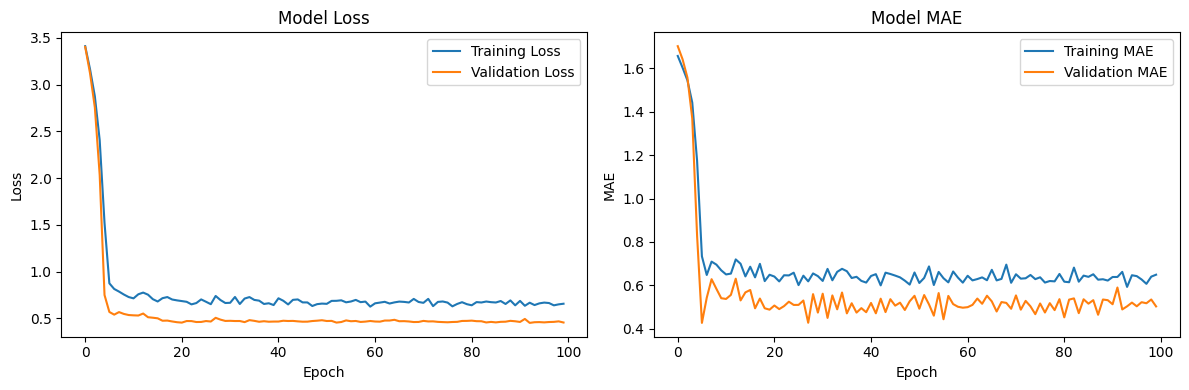

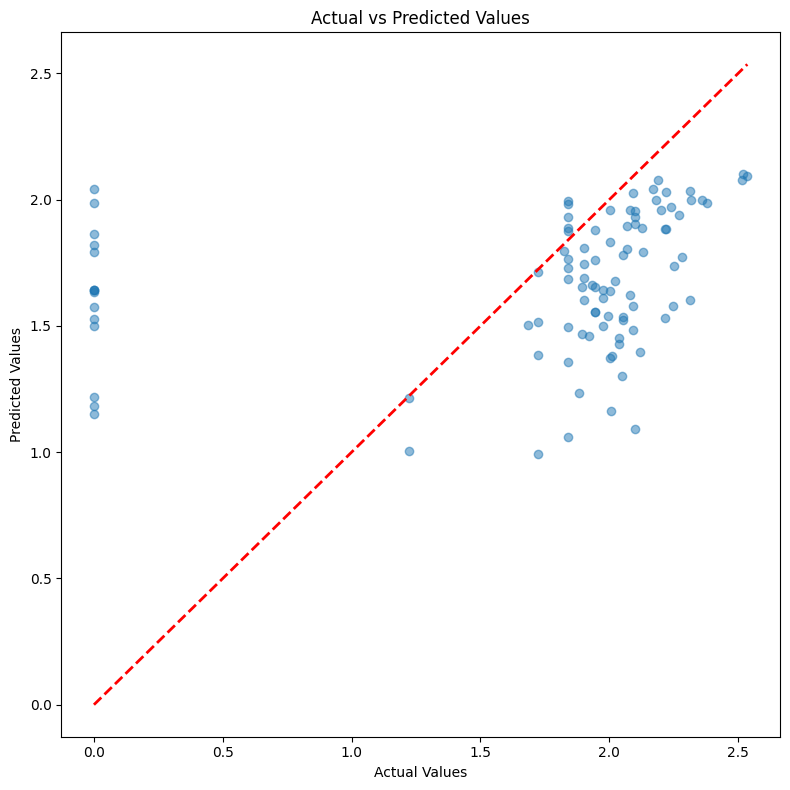

In [143]:
print("\nTraining LSTM model with pre-optimized parameters...")

# Define optimized parameters directly instead of re-running optimization
lstm_params = {
    'lstm_layers': np.float64(47.0), 
    'dense_layers': np.float64(90.0), 
    'dropout_rate': np.float64(0.40082374738014737), 
    'learning_rate': np.float64(0.0005524777639220163)
}

# Create LSTM model with the optimized parameters
lstm_model = build_lstm_model(
    input_shape=(X_train.shape[1],),
    lstm_layers=[int(lstm_params['lstm_layers']), int(lstm_params['lstm_layers'])//2],
    dense_layers=[int(lstm_params['dense_layers'])],
    dropout_rate=lstm_params['dropout_rate'],
    learning_rate=lstm_params['learning_rate']
)

# Define a modified train_model function that handles pandas Series
def train_model_fixed(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    # Convert pandas Series to numpy arrays if needed
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_val, pd.Series):
        y_val = y_val.values
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    # Create datasets and dataloaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    
    # Move model to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Training history - FIXED KEY NAMES to match plot_training_history expectations
    # Training history with the keys expected by plot_training_history
    history = {
        'loss': [],
        'val_loss': [],
        'mae': [],
        'val_mae': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero gradients
            model.optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = model.loss_fn(outputs, targets)
            
            # Calculate MAE
            mae = torch.mean(torch.abs(outputs - targets))
            
            # Backward pass and optimize
            loss.backward()
            
            # Add gradient clipping to prevent NaN values
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            model.optimizer.step()
            
            train_loss += loss.item()
            train_mae += mae.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = model.loss_fn(outputs, targets)
                mae = torch.mean(torch.abs(outputs - targets))
                val_loss += loss.item()
                val_mae += mae.item()
        
        # Record history
        history['loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['mae'].append(train_mae / len(train_loader))
        history['val_mae'].append(val_mae / len(val_loader))
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Loss: {history['loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, "
                  f"MAE: {history['mae'][-1]:.4f}, Val MAE: {history['val_mae'][-1]:.4f}")
    
    return history

# Train the model with the fixed function
print("\nTraining LSTM model with optimized parameters...")
lstm_history = train_model_fixed(lstm_model, X_train, y_train, X_val, y_val, epochs=100)
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)
print("\nLSTM Model Metrics:")
print(lstm_metrics)
plot_training_history(lstm_history)
plot_predictions(y_test, lstm_model.predict(X_test))

## 2. Attention


Optimizing Attention model...
Using device: cuda:0
Trial 1/20
Parameters: {'lstm_units': 246, 'dense_units': 77, 'dropout_rate': 0.3633143854869175, 'learning_rate': 0.00865575158800497}
Cross-validation score: -0.6961
Trial 2/20
Parameters: {'lstm_units': 254, 'dense_units': 95, 'dropout_rate': 0.20507322547661466, 'learning_rate': 0.005494533588835035}
Cross-validation score: -0.6850
Trial 3/20
Parameters: {'lstm_units': 114, 'dense_units': 34, 'dropout_rate': 0.40367587553292694, 'learning_rate': 0.008017560217827317}
Cross-validation score: -0.7095
Trial 4/20
Parameters: {'lstm_units': 134, 'dense_units': 56, 'dropout_rate': 0.10083137472291553, 'learning_rate': 0.00977675486380753}
Cross-validation score: -0.7058
Trial 5/20
Parameters: {'lstm_units': 63, 'dense_units': 28, 'dropout_rate': 0.21294015837795244, 'learning_rate': 0.007349186937537068}
Cross-validation score: -0.7060
Trial 6/20
Parameters: {'lstm_units': np.float64(252.0), 'dense_units': np.float64(108.0), 'dropout_ra

d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 11/20
Parameters: {'lstm_units': np.float64(223.0), 'dense_units': np.float64(24.0), 'dropout_rate': np.float64(0.13175776056310928), 'learning_rate': np.float64(0.0050466500691724175)}
Cross-validation score: -0.6980


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 12/20
Parameters: {'lstm_units': np.float64(214.0), 'dense_units': np.float64(111.0), 'dropout_rate': np.float64(0.4129883577670995), 'learning_rate': np.float64(0.002838718736778969)}
Cross-validation score: -0.7911


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 13/20
Parameters: {'lstm_units': np.float64(238.0), 'dense_units': np.float64(113.0), 'dropout_rate': np.float64(0.49229017094728167), 'learning_rate': np.float64(0.002283925091443373)}
Cross-validation score: -0.6826


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 14/20
Parameters: {'lstm_units': np.float64(200.0), 'dense_units': np.float64(26.0), 'dropout_rate': np.float64(0.20983477001879605), 'learning_rate': np.float64(0.005325891259287085)}
Cross-validation score: -0.6992


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 15/20
Parameters: {'lstm_units': np.float64(41.0), 'dense_units': np.float64(68.0), 'dropout_rate': np.float64(0.11944052331609854), 'learning_rate': np.float64(0.009190473675247758)}
Cross-validation score: -0.7042


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 16/20
Parameters: {'lstm_units': np.float64(93.0), 'dense_units': np.float64(67.0), 'dropout_rate': np.float64(0.2833781642996345), 'learning_rate': np.float64(0.0051876150313324215)}
Cross-validation score: -0.6933


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 17/20
Parameters: {'lstm_units': np.float64(159.0), 'dense_units': np.float64(99.0), 'dropout_rate': np.float64(0.4534046510821469), 'learning_rate': np.float64(0.008863244698181996)}
Cross-validation score: -0.6880


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 18/20
Parameters: {'lstm_units': np.float64(130.0), 'dense_units': np.float64(84.0), 'dropout_rate': np.float64(0.40901015911369265), 'learning_rate': np.float64(0.005710168133943863)}
Cross-validation score: -0.7084


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 19/20
Parameters: {'lstm_units': np.float64(156.0), 'dense_units': np.float64(60.0), 'dropout_rate': np.float64(0.3381888745652926), 'learning_rate': np.float64(0.004949768186433385)}
Cross-validation score: -0.6853


d:\Work_Space\ImagoAI\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Trial 20/20
Parameters: {'lstm_units': np.float64(223.0), 'dense_units': np.float64(23.0), 'dropout_rate': np.float64(0.3007101062847547), 'learning_rate': np.float64(0.008352235464218203)}
Cross-validation score: -0.6920

Best parameters found:
{'lstm_units': np.float64(238.0), 'dense_units': np.float64(113.0), 'dropout_rate': np.float64(0.49229017094728167), 'learning_rate': np.float64(0.002283925091443373)}
Best cross-validation score: -0.6826

Training Attention model with optimized parameters...
Epoch 1/100 - loss: 2.0598 - mae: 1.2487 - val_loss: 0.8910 - val_mae: 0.9229
Epoch 2/100 - loss: 0.9172 - mae: 0.7529 - val_loss: 0.5956 - val_mae: 0.6854
Epoch 3/100 - loss: 0.7938 - mae: 0.7306 - val_loss: 0.5402 - val_mae: 0.5998
Epoch 4/100 - loss: 0.7309 - mae: 0.6813 - val_loss: 0.5131 - val_mae: 0.5137
Epoch 5/100 - loss: 0.7835 - mae: 0.6963 - val_loss: 0.5538 - val_mae: 0.6268
Epoch 6/100 - loss: 0.7611 - mae: 0.6957 - val_loss: 0.5272 - val_mae: 0.5734
Epoch 7/100 - loss: 0.7961

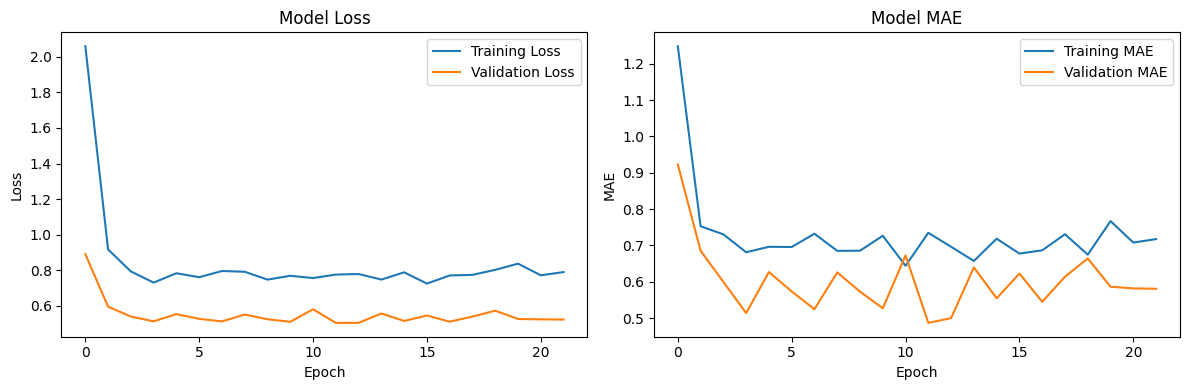

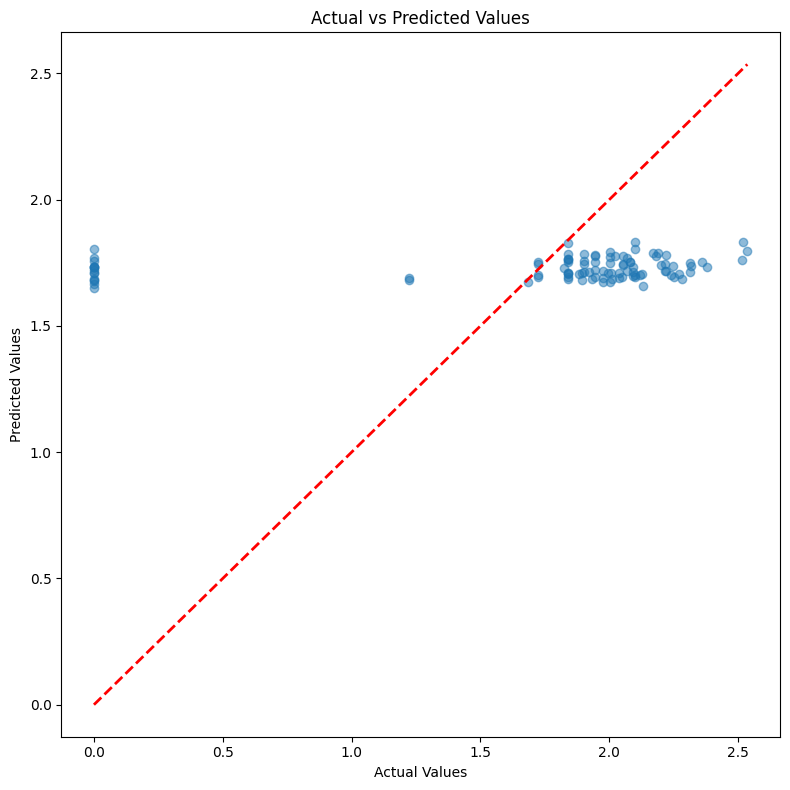

In [144]:
# Attention Model
print("\nOptimizing Attention model...")
def create_attention(params):
    return build_attention_model(
        input_shape=(X_train.shape[1],),
        lstm_units=int(params['lstm_units']),
        dense_units=int(params['dense_units']),
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

attention_params = optimize_hyperparameters(
    create_attention, ATTENTION_PARAM_RANGES, X_train, y_train, n_trials=20
)

print("\nTraining Attention model with optimized parameters...")
attention_model = create_attention(attention_params)
attention_history = train_model(attention_model, X_train, y_train, X_val, y_val, epochs=100)
attention_metrics = evaluate_model(attention_model, X_test, y_test)
print("\nAttention Model Metrics:")
print(attention_metrics)
plot_training_history(attention_history)
plot_predictions(y_test, attention_model.predict(X_test))

## 3. Neural Network


Optimizing Neural Network model...
Using device: cuda:0
Trial 1/20
Parameters: {'hidden_layers': 153, 'num_layers': 1, 'dropout_rate': 0.22820034450262355, 'learning_rate': 0.0002498191429422491}
Cross-validation score: -1.2090
Trial 2/20
Parameters: {'hidden_layers': 136, 'num_layers': 3, 'dropout_rate': 0.2321335415241991, 'learning_rate': 0.00027561735809478557}
Cross-validation score: -0.9713
Trial 3/20
Parameters: {'hidden_layers': 244, 'num_layers': 2, 'dropout_rate': 0.25220223609276127, 'learning_rate': 0.0007221981993865891}
Cross-validation score: -1.0442
Trial 4/20
Parameters: {'hidden_layers': 210, 'num_layers': 4, 'dropout_rate': 0.12289100544417031, 'learning_rate': 0.0006039916134201886}
Cross-validation score: -0.9346
Trial 5/20
Parameters: {'hidden_layers': 151, 'num_layers': 1, 'dropout_rate': 0.3971406901596629, 'learning_rate': 0.0006589808607525916}
Cross-validation score: -1.1574
Trial 6/20
Parameters: {'hidden_layers': np.float64(207.0), 'num_layers': np.float64

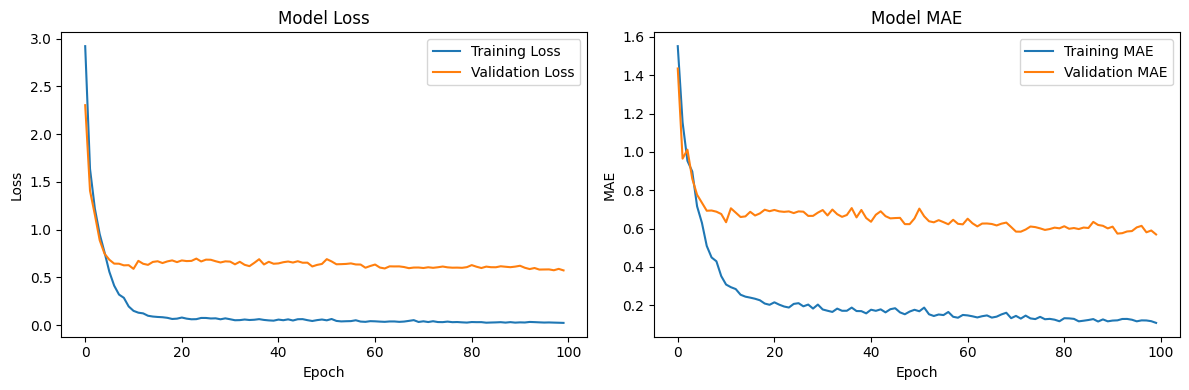

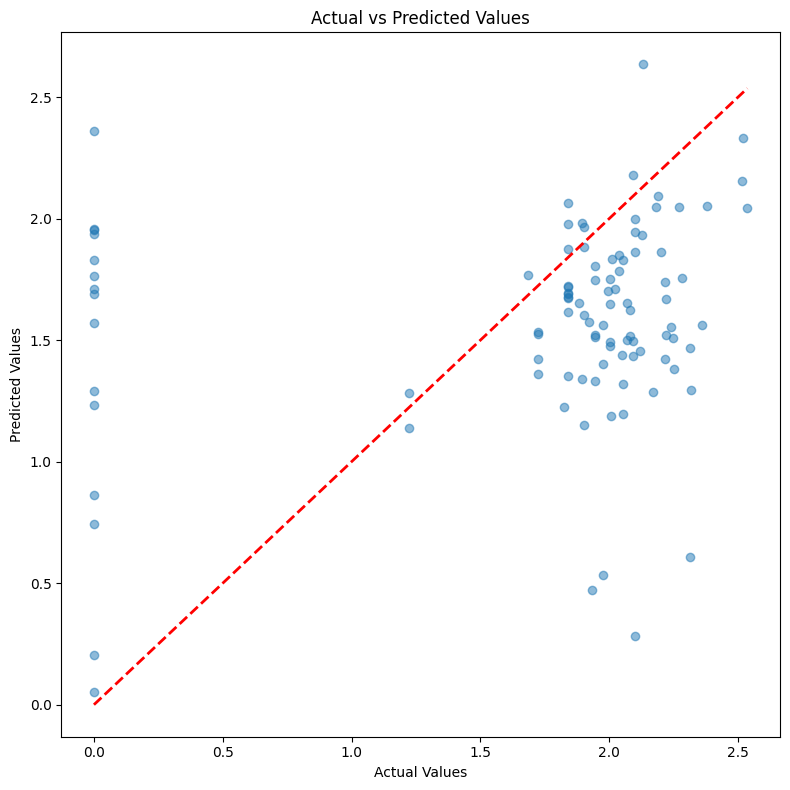

In [148]:
# Neural Network Model
print("\nOptimizing Neural Network model...")
def create_nn(params):
    return build_nn_model(
        input_shape=(X_train.shape[1],),
        hidden_layers=int(params['hidden_layers']),
        num_layers=int(params['num_layers']),
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

nn_params = optimize_hyperparameters(
    create_nn, NN_PARAM_RANGES, X_train, y_train, n_trials=20
)

print("\nTraining Neural Network model with optimized parameters...")
nn_model = create_nn(nn_params)
nn_history = train_model_fixed(nn_model, X_train, y_train, X_val, y_val, epochs=100)
nn_metrics = evaluate_model(nn_model, X_test, y_test)
print("\nNeural Network Model Metrics:")
print(nn_metrics)
plot_training_history(nn_history)
plot_predictions(y_test, nn_model.predict(X_test))

## 4. CNN


Training CNN model with predefined parameters...
Epoch 10/100, Loss: 0.5980, Val Loss: 0.7908, MAE: 0.6051, Val MAE: 0.8672
Epoch 20/100, Loss: 0.5072, Val Loss: 0.7001, MAE: 0.5929, Val MAE: 0.7863
Epoch 30/100, Loss: 0.2941, Val Loss: 0.8661, MAE: 0.4439, Val MAE: 0.8571
Epoch 40/100, Loss: 0.2180, Val Loss: 0.9176, MAE: 0.3790, Val MAE: 0.8815
Epoch 50/100, Loss: 0.2172, Val Loss: 0.7269, MAE: 0.3807, Val MAE: 0.7594
Epoch 60/100, Loss: 0.1975, Val Loss: 0.8228, MAE: 0.3696, Val MAE: 0.8191
Epoch 70/100, Loss: 0.1684, Val Loss: 0.8697, MAE: 0.3319, Val MAE: 0.8570
Epoch 80/100, Loss: 0.1874, Val Loss: 0.7705, MAE: 0.3513, Val MAE: 0.7927
Epoch 90/100, Loss: 0.1740, Val Loss: 0.8676, MAE: 0.3429, Val MAE: 0.8577
Epoch 100/100, Loss: 0.1796, Val Loss: 0.7380, MAE: 0.3508, Val MAE: 0.7746

CNN Model Metrics:
{'MAE': 0.8315979657148072, 'RMSE': np.float64(0.9292424637993243), 'R2': -0.5353529851849654}


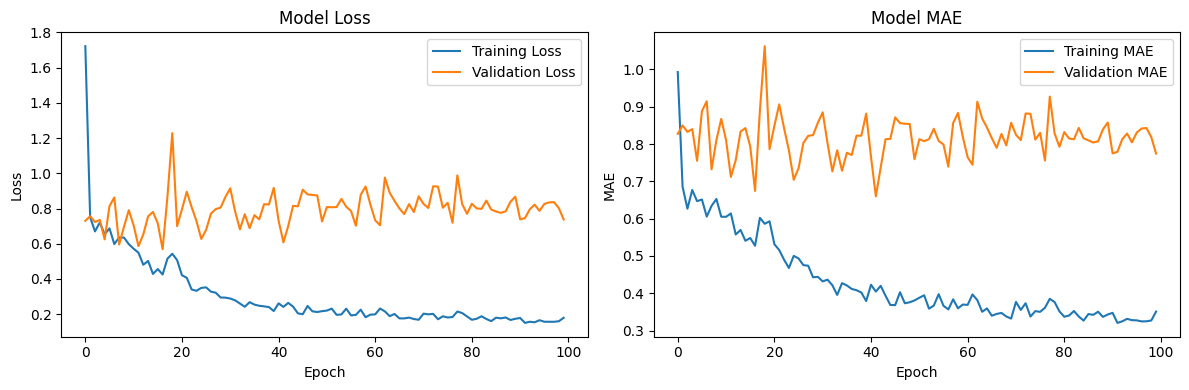

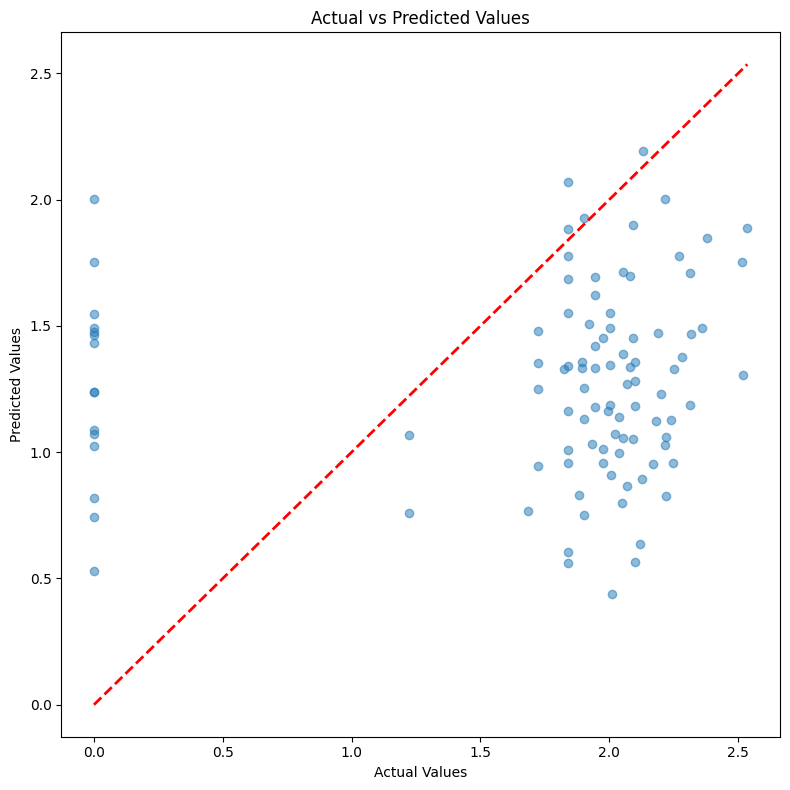

In [ ]:
# CNN Model
print("\nTraining CNN model with predefined parameters...")
cnn_params = {
    'filters': 32, 
    'kernel_size': 3,  
    'dense_layers': 64,
    'dropout_rate': 0.3,
    'learning_rate': 0.0005
}

cnn_model = build_cnn_model(
    input_shape=(X_train.shape[1],),
    filters=int(cnn_params['filters']),
    kernel_size=int(cnn_params['kernel_size']),
    dense_layers=int(cnn_params['dense_layers']),
    dropout_rate=cnn_params['dropout_rate'],
    learning_rate=cnn_params['learning_rate']
)

# Clean data before training
X_train_clean = np.nan_to_num(X_train, nan=0.0)
y_train_clean = np.nan_to_num(y_train, nan=0.0)
X_val_clean = np.nan_to_num(X_val, nan=0.0)
y_val_clean = np.nan_to_num(y_val, nan=0.0)
X_test_clean = np.nan_to_num(X_test, nan=0.0)
y_test_clean = np.nan_to_num(y_test, nan=0.0)

# Train the model
cnn_history = train_model_fixed(cnn_model, X_train_clean, y_train_clean, X_val_clean, y_val_clean, epochs=100)
cnn_metrics = evaluate_model(cnn_model, X_test_clean, y_test_clean)
print("\nCNN Model Metrics:")
print(cnn_metrics)
plot_training_history(cnn_history)
plot_predictions(y_test_clean, cnn_model.predict(X_test_clean))

In [153]:
import os
import numpy as np

# Results dictionary with updated keys and structure
results = {
    'lstm': {
        'metrics': lstm_metrics,
        'params': lstm_params
    },
    'cnn': {
        'metrics': cnn_metrics,
        'params': cnn_params
    },
    'nn': {
        'metrics': nn_metrics,
        'params': nn_params
    },
    'data_info': {
        'total_samples': len(df),
        'features': list(df.columns),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test)
    },
    'dimensionality_reduction': {
        'pca_components': X_pca.shape[1],
        'tsne_components': X_tsne.shape[1]
    }
}

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Save metrics to file
with open(os.path.join('results', 'metrics.txt'), 'w') as f:
    f.write("Data Processing Information:\n")
    f.write("-" * 50 + "\n")
    f.write(f"Total samples: {results['data_info']['total_samples']}\n")
    f.write(f"Number of features: {len(results['data_info']['features'])}\n")
    f.write(f"Training set size: {results['data_info']['train_size']}\n")
    f.write(f"Validation set size: {results['data_info']['val_size']}\n")
    f.write(f"Test set size: {results['data_info']['test_size']}\n\n")
    
    f.write("Dimensionality Reduction Information:\n")
    f.write("-" * 50 + "\n")
    f.write(f"PCA components retained: {results['dimensionality_reduction']['pca_components']}\n")
    f.write(f"t-SNE components retained: {results['dimensionality_reduction']['tsne_components']}\n\n")
    
    f.write("Model Performance:\n")
    f.write("-" * 50 + "\n")
    
    for model_name in ['lstm', 'cnn', 'nn']:
        metrics = results[model_name]['metrics']
        params = results[model_name]['params']
        
        f.write(f"{model_name.upper()} Model:\n")
        
        # Check for different possible metric keys and handle missing metrics gracefully
        # For MAE (might be stored as 'mae' or 'mean_absolute_error')
        if 'mae' in metrics:
            f.write(f"  MAE: {metrics['mae']:.4f}\n")
        elif 'mean_absolute_error' in metrics:
            f.write(f"  MAE: {metrics['mean_absolute_error']:.4f}\n")
        else:
            f.write(f"  MAE: N/A\n")
            
        # For RMSE (might be stored as 'rmse' or 'root_mean_squared_error')
        if 'rmse' in metrics:
            f.write(f"  RMSE: {metrics['rmse']:.4f}\n")
        elif 'root_mean_squared_error' in metrics:
            f.write(f"  RMSE: {metrics['root_mean_squared_error']:.4f}\n")
        else:
            f.write(f"  RMSE: N/A\n")
            
        # For R² (might be stored as 'r2' or 'r2_score')
        if 'r2' in metrics:
            f.write(f"  R²: {metrics['r2']:.4f}\n\n")
        elif 'r2_score' in metrics:
            f.write(f"  R²: {metrics['r2_score']:.4f}\n\n")
        else:
            f.write(f"  R²: N/A\n\n")
        
        f.write(f"  Optimal Parameters:\n")
        for param, value in params.items():
            if isinstance(value, np.float64):  # Convert numpy float64 to native Python float for better readability
                value = float(value)
            f.write(f"    {param}: {value}\n")
        f.write("\n")

print("\nResults saved to 'results/metrics.txt'")
print("\nAnalysis complete!")


Results saved to 'results/metrics.txt'

Analysis complete!
